In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.stats import genextreme , norm

#for MCMC
import pymc as pm
import pymc_extras.distributions as pmx
import arviz as az
from arviz.plots import plot_utils as azpu

#for plotting
from matplotlib.collections import LineCollection
import seaborn as sns

In [87]:
dat = pd.read_csv("data/cao_index_yearly.csv",sep=";")
#dat = dat.set_index('year')

In [88]:
GSTM = pd.read_fwf("data/GSTM.txt")
#GSTM = GSTM.set_index('year')

In [89]:
zhou = pd.read_csv("data/Zhou_2024.csv",sep=",")
zhou = zhou.rename(columns={"years": "year"})
zhou = zhou[["year","IPO","AM"]]

In [90]:
dat = dat.merge(GSTM,on='year')
dat = dat.merge(zhou,on='year',how='left')

In [91]:
dat.head(5)

year    time_min    time_max  t2min_weighted_mean  cao_index_max  \
0  1941.0  1940-12-01  1941-02-28               -7.883          0.828   
1  1942.0  1941-12-01  1942-02-28               -9.422          1.973   
2  1943.0  1942-12-01  1943-02-28               -8.382          1.828   
3  1944.0  1943-12-01  1944-02-29               -7.103          0.581   
4  1945.0  1944-12-01  1945-02-28               -8.523          1.667   

   No_Smoothing  GSTM  IPO  AM  
0          0.18  0.09  NaN NaN  
1          0.06  0.10  NaN NaN  
2          0.09  0.10  NaN NaN  
3          0.20  0.07  NaN NaN  
4          0.09  0.04  NaN NaN

In [92]:
y = np.array(dat['cao_index_max'])
x = np.array((dat['GSTM'] - dat['GSTM'].mean())/dat['GSTM'].std())
p = 1/100
with pm.Model() as stationary_gev:
    μ = pm.Normal("μ",  mu=0,sigma=2.5)
    σ = pm.HalfNormal("σ", sigma=5)
    ξ = pm.TruncatedNormal("ξ", mu=-0.2, sigma=0.1, lower=-0.6, upper=0.1)

    gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ, observed=y)
    z_p = pm.Deterministic("z_p", μ - σ / ξ * (1 - (-np.log(1 - p)) ** (-ξ)))

with pm.Model() as no_stationary_gev:

    B0 = pm.Normal("B0",  mu=0,sigma=5)
    B1 = pm.Normal("B1",  mu=0,sigma=5)
    μ = B0 + B1 * x
    σ = pm.HalfNormal("σ", sigma=5)
    ξ = pm.TruncatedNormal("ξ", mu=-0.2, sigma=0.1, lower=-0.6, upper=-0.05)

    gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ, observed=y)
    z_p = pm.Deterministic("z_p", μ - σ / ξ * (1 - (-np.log(1 - p)) ** (-ξ)))

In [93]:
with stationary_gev:
    idata_statio = pm.sample(5000,cores=4,chains=4,tune=2000, random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ξ]


Output()

Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 3 seconds.
There were 1311 divergences after tuning. Increase `target_accept` or reparameterize.


In [94]:
with no_stationary_gev:
    idata_nostatio = pm.sample(5000,cores=4,chains=4,tune=2000, random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [B0, B1, σ, ξ]


Output()

Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 3 seconds.
There were 1110 divergences after tuning. Increase `target_accept` or reparameterize.


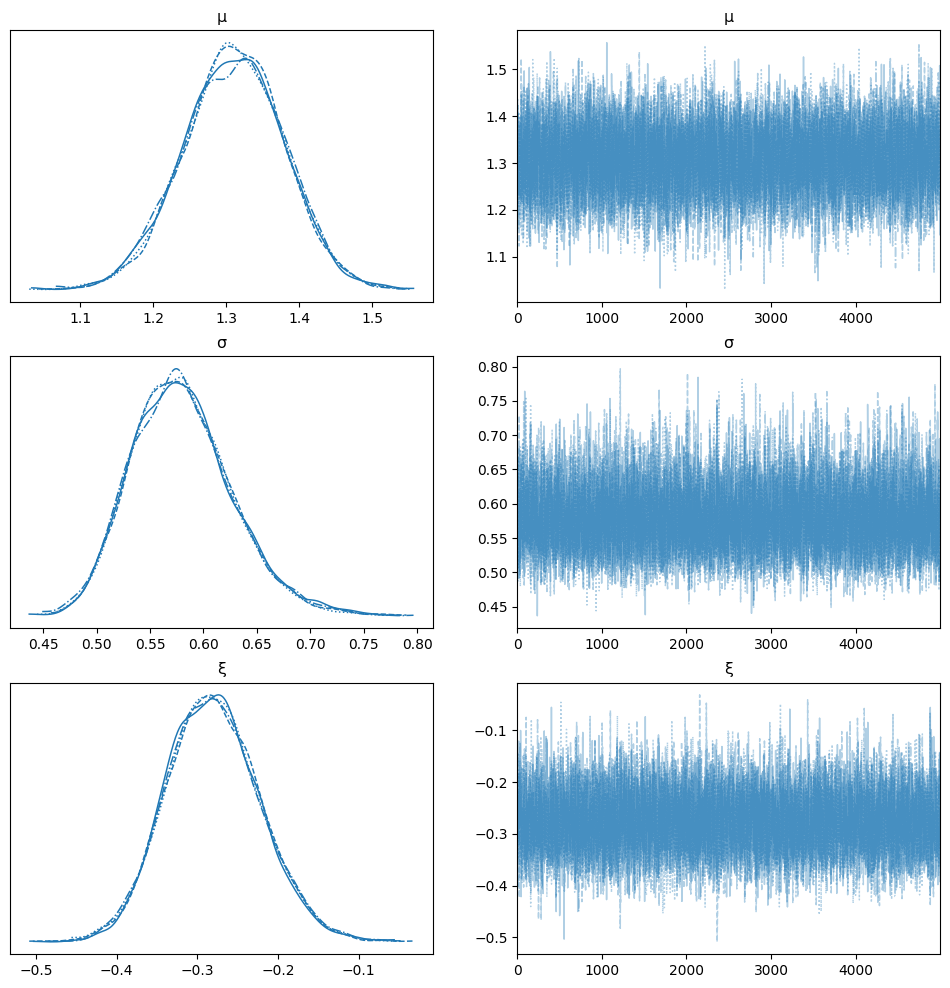

In [95]:
az.plot_trace(idata_statio,var_names=["μ","σ","ξ"], figsize=(12, 12),divergences=False);

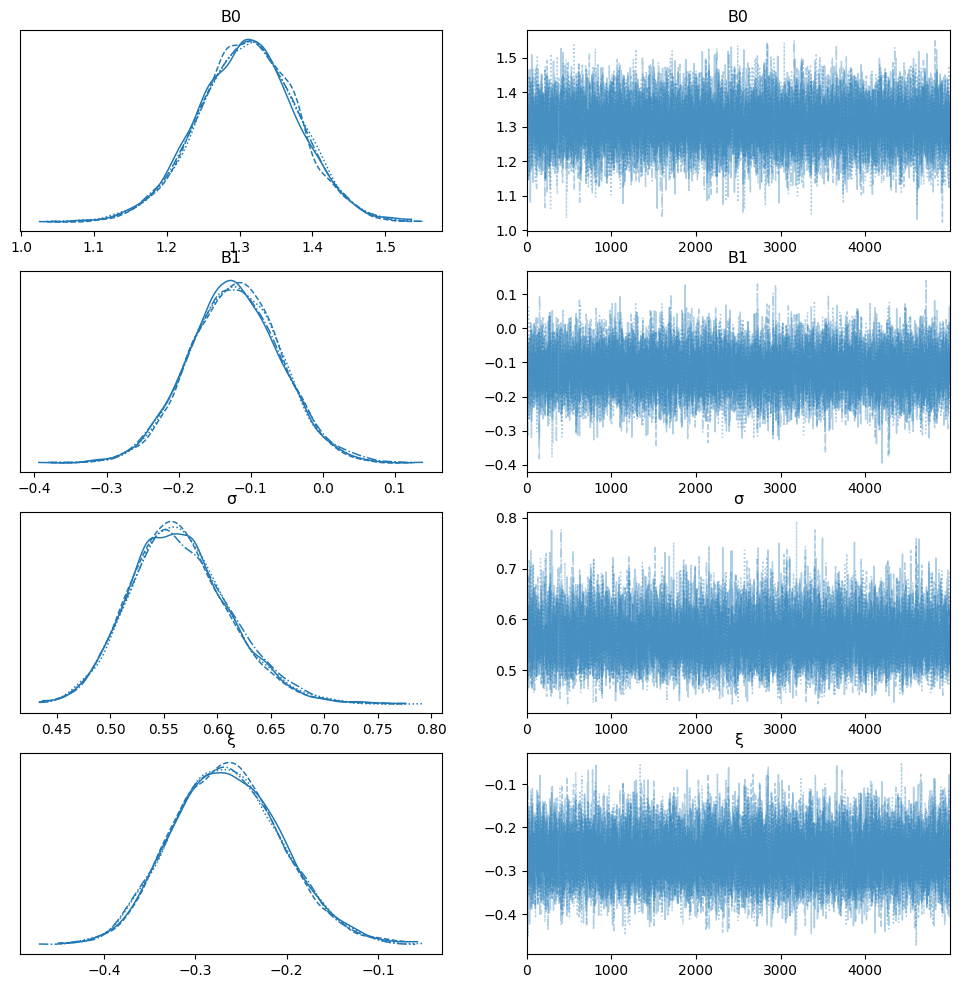

In [96]:
az.plot_trace(idata_nostatio,var_names=["B0","B1","σ","ξ"], figsize=(12, 12),divergences=False);

In [97]:
with stationary_gev:
    pm.sample_posterior_predictive(idata_statio, extend_inferencedata=True)

with no_stationary_gev:
    pm.sample_posterior_predictive(idata_nostatio, extend_inferencedata=True)

Sampling: [gev]


Output()

Sampling: [gev]


Output()

### Stationary GEV posterior distributions

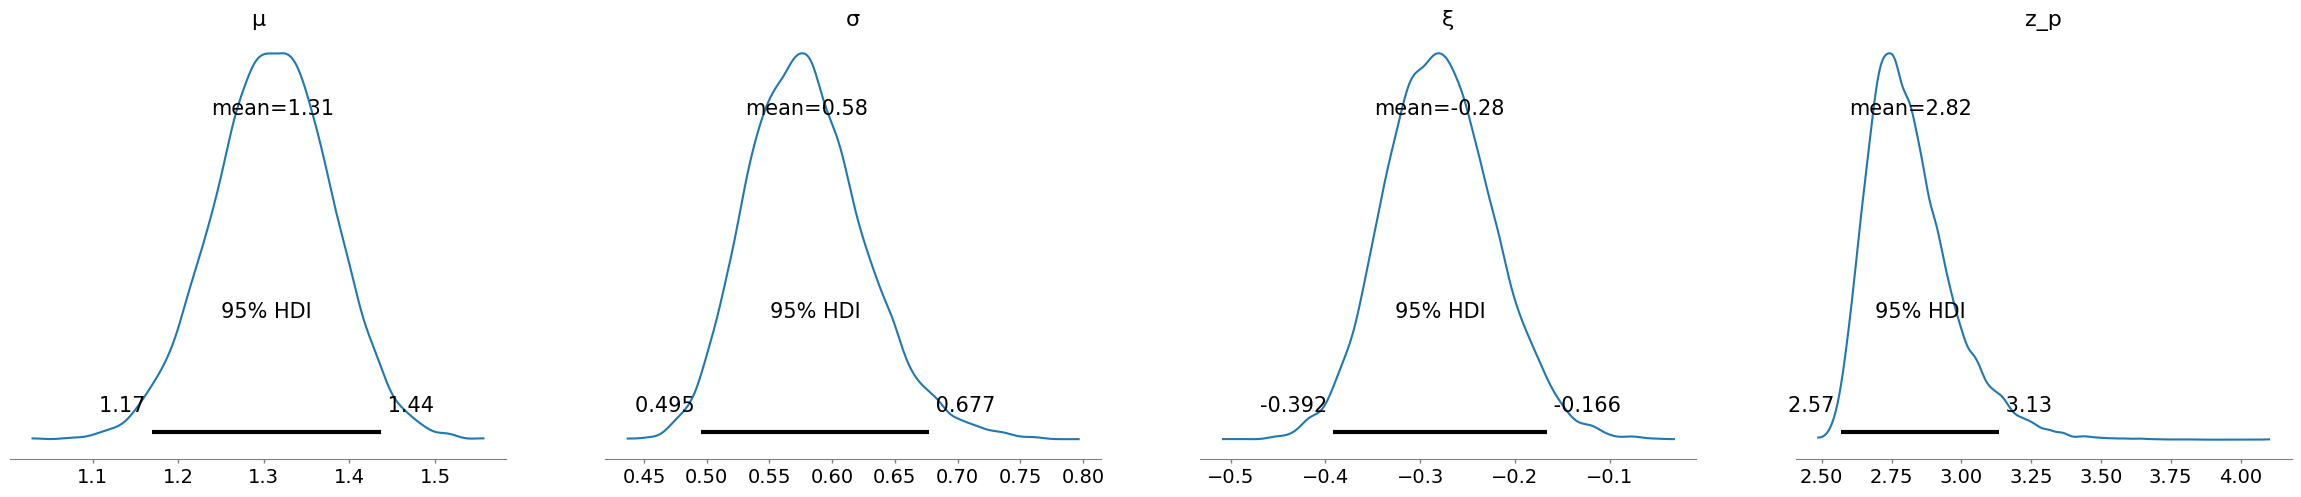

In [98]:
az.plot_posterior(idata_statio, hdi_prob=0.95, round_to=3);

### Non-stationary GEV posterior distributions

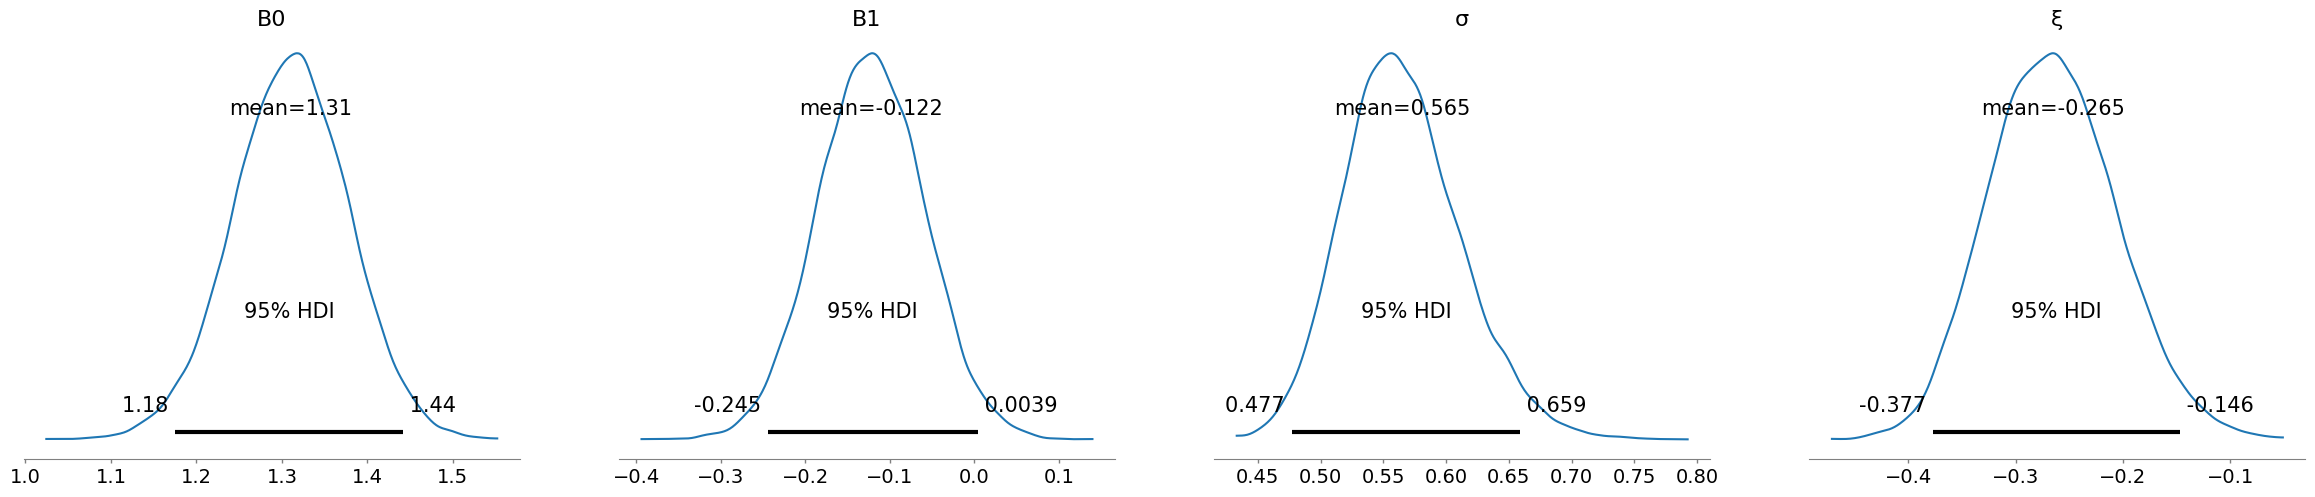

In [99]:
az.plot_posterior(idata_nostatio,var_names=["B0","B1","σ","ξ"], hdi_prob=0.95, round_to=3);

In [100]:
with stationary_gev:
    pm.compute_log_likelihood(idata_statio)

with no_stationary_gev:
    pm.compute_log_likelihood(idata_nostatio)

Output()

Output()

In [101]:
az.compare({"statio": idata_statio, "nostatio": idata_nostatio},ic='waic')

rank  elpd_waic    p_waic  elpd_diff   weight        se       dse  \
nostatio     0 -70.736644  3.057656   0.000000  0.72062  5.448025  0.000000   
statio       1 -71.504067  2.142618   0.767424  0.27938  5.647895  1.878935   

          warning scale  
nostatio    False   log  
statio      False   log

### 100-year return level distributions

In [104]:
df_zp_no = idata_statio.posterior["z_p"].to_dataframe().reset_index()
df_zp = idata_nostatio.posterior["z_p"].to_dataframe().reset_index()


In [109]:
df_zp[df_zp.z_p_dim_0 == 0]["z_p"].quantile([0.025,0.975])

0.025    2.644194
0.975    3.290421
Name: z_p, dtype: float64

In [110]:
np.max(y)

np.float64(2.797)

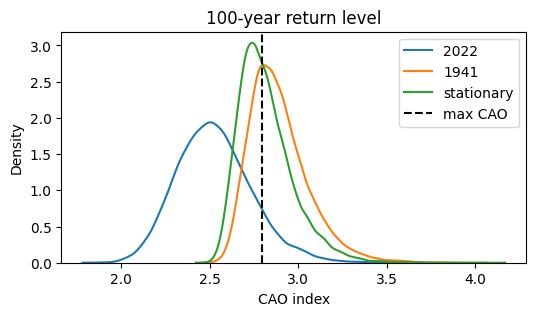

In [ ]:

plt.figure(figsize=(6,3))
sns.kdeplot(df_zp[df_zp.z_p_dim_0 == 81]["z_p"], label="2022");
sns.kdeplot(df_zp[df_zp.z_p_dim_0 == 0]["z_p"], label="1941");
sns.kdeplot(df_zp_no["z_p"],label="stationary")
plt.axvline(np.max(y),color="black",linestyle="dashed",label="max CAO")
plt.title("100-year return level")
plt.xlabel("CAO index")
plt.legend();


# adding internal variability

In [20]:
dat = dat.dropna()
dat.head(2)

y = np.array(dat['cao_index_max'])
x = np.array((dat['GSTM'] - dat['GSTM'].mean())/dat['GSTM'].std())
w = np.array((dat['IPO'] - dat['IPO'].mean())/dat['IPO'].std())
z = np.array((dat['AM'] - dat['AM'].mean())/dat['AM'].std())


In [21]:
with pm.Model() as stationary_gev:
    μ = pm.Normal("μ",  mu=0,sigma=2.5)
    σ = pm.HalfNormal("σ", sigma=5)
    ξ = pm.TruncatedNormal("ξ", mu=-0.2, sigma=0.1, lower=-0.6, upper=0.1)

    gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ, observed=y)
    z_p = pm.Deterministic("z_p", μ - σ / ξ * (1 - (-np.log(1 - p)) ** (-ξ)))


with stationary_gev:
    idata_statio = pm.sample(5000,cores=4,chains=4,tune=2000, random_seed=42)

with stationary_gev:
    pm.sample_posterior_predictive(idata_statio, extend_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ξ]


Output()

Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 2 seconds.
There were 1102 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [gev]


Output()

In [22]:
with pm.Model() as no_stationary_gev:

    B0 = pm.Normal("B0",  mu=0,sigma=5)
    B1 = pm.Normal("B1",  mu=0,sigma=5)
    μ = B0 + B1 * x
    σ = pm.HalfNormal("σ", sigma=5)
    ξ = pm.TruncatedNormal("ξ", mu=-0.2, sigma=0.1, lower=-0.6, upper=-0.05)

    gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ, observed=y)
    z_p = pm.Deterministic("z_p", μ - σ / ξ * (1 - (-np.log(1 - p)) ** (-ξ)))

with no_stationary_gev:
    idata_nostatio = pm.sample(5000,cores=4,chains=4,tune=2000, random_seed=42)

with no_stationary_gev:
    pm.sample_posterior_predictive(idata_nostatio, extend_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [B0, B1, σ, ξ]


Output()

Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 3 seconds.
There were 1083 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [gev]


Output()

In [23]:
with pm.Model() as complex_stationary_gev:

    B0 = pm.Normal("B0",  mu=0,sigma=5)
    B1 = pm.Normal("B1",  mu=0,sigma=5)
    B2 = pm.Normal("B2",  mu=0,sigma=5)
    B3 = pm.Normal("B3",  mu=0,sigma=5)

    μ = B0 + B1 * x + B2 * w + B3 * z
    σ = pm.HalfNormal("σ", sigma=5)
    ξ = pm.TruncatedNormal("ξ", mu=-0.2, sigma=0.1, lower=-0.6, upper=-0.05)

    gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ, observed=y)
    z_p = pm.Deterministic("z_p", μ - σ / ξ * (1 - (-np.log(1 - p)) ** (-ξ)))


with complex_stationary_gev:
    idata_complex = pm.sample(5000,cores=4,chains=4,tune=2000, random_seed=42)

with complex_stationary_gev:
    pm.sample_posterior_predictive(idata_complex, extend_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [B0, B1, B2, B3, σ, ξ]


Output()

Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 3 seconds.
There were 1884 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [gev]


Output()

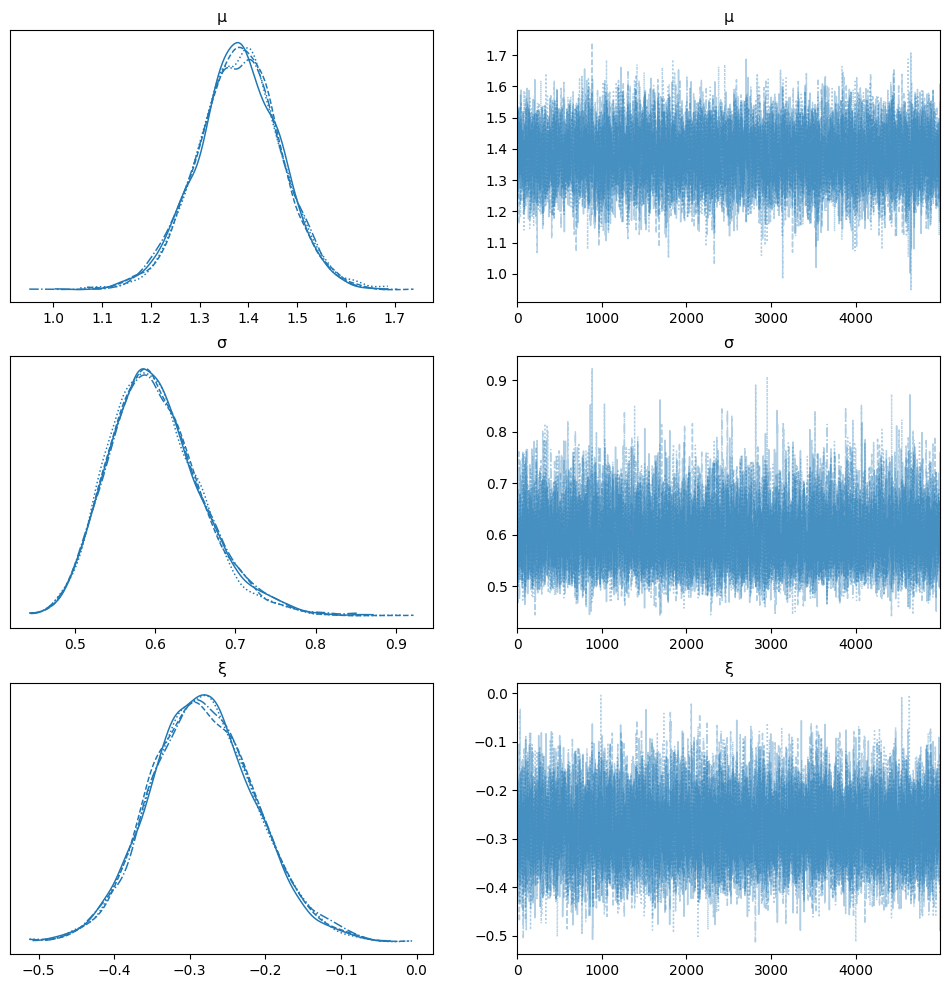

In [24]:
az.plot_trace(idata_statio,var_names=["μ","σ","ξ"], figsize=(12, 12),divergences=False);

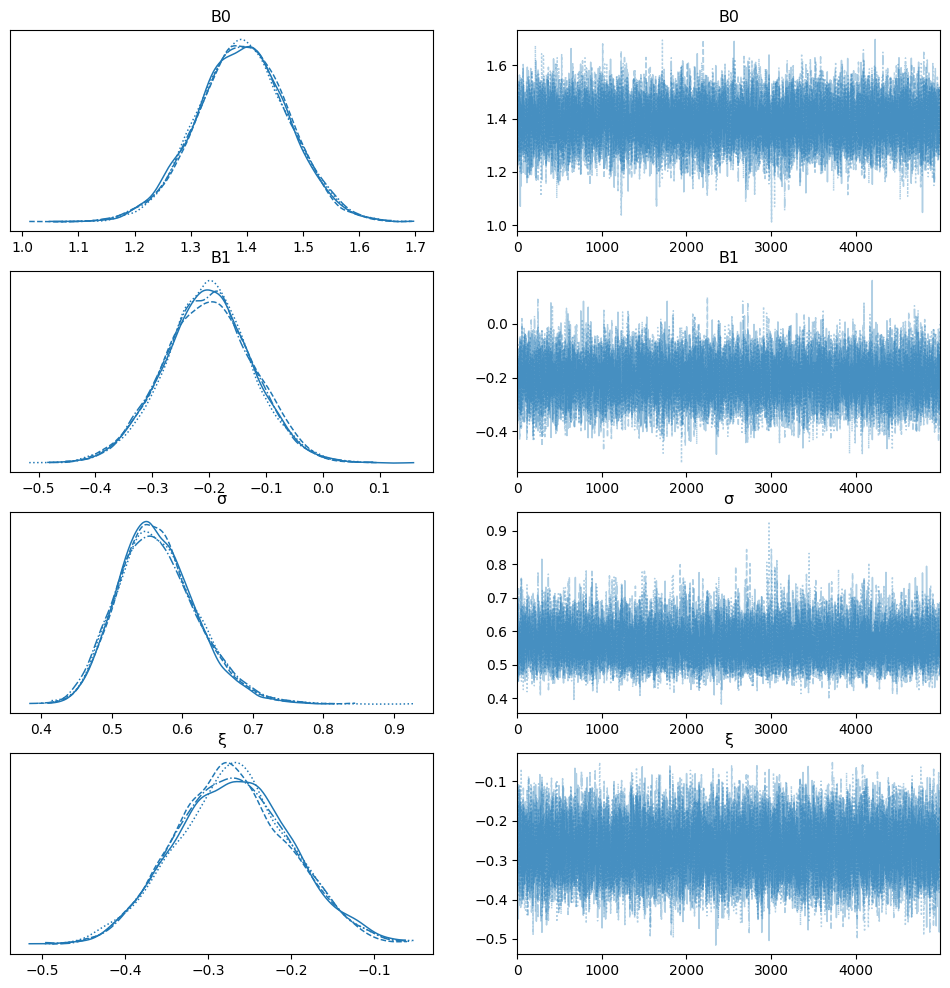

In [25]:
az.plot_trace(idata_nostatio,var_names=["B0","B1","σ","ξ"], figsize=(12, 12),divergences=False);

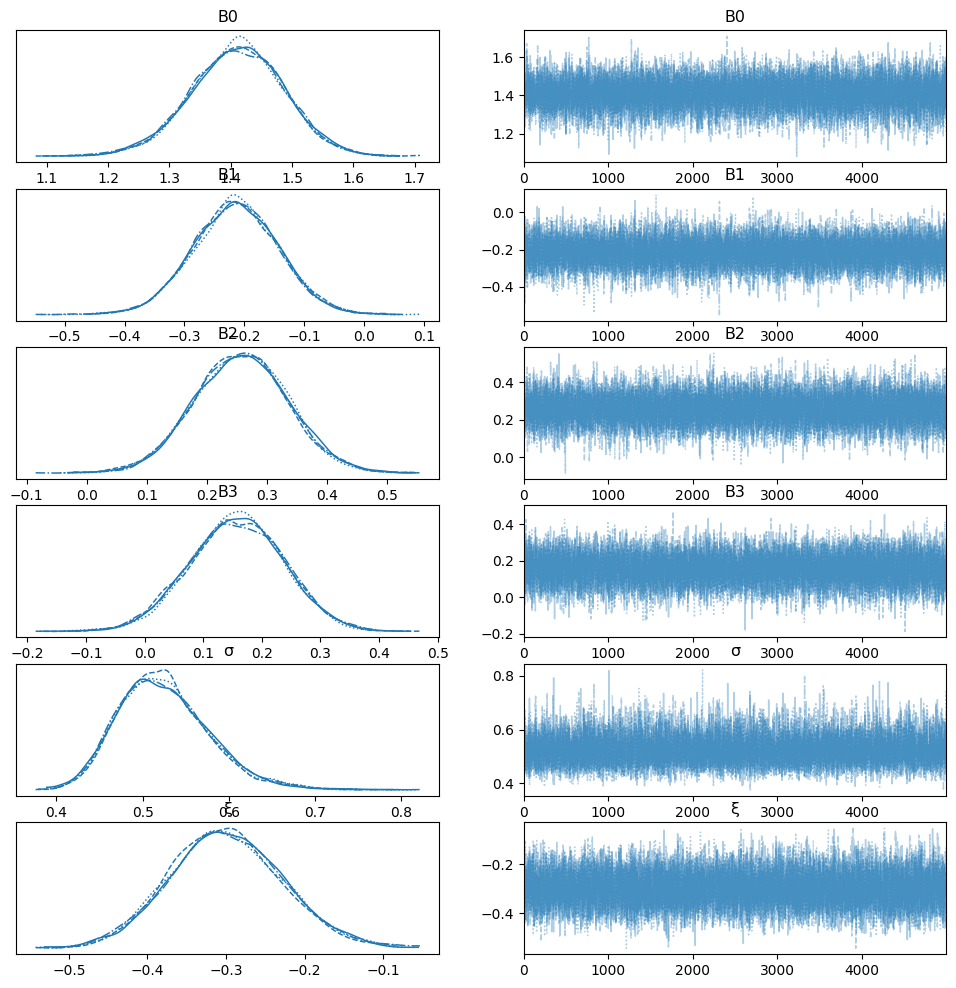

In [26]:
az.plot_trace(idata_complex,var_names=["B0","B1","B2","B3","σ","ξ"], figsize=(12, 12),divergences=False);

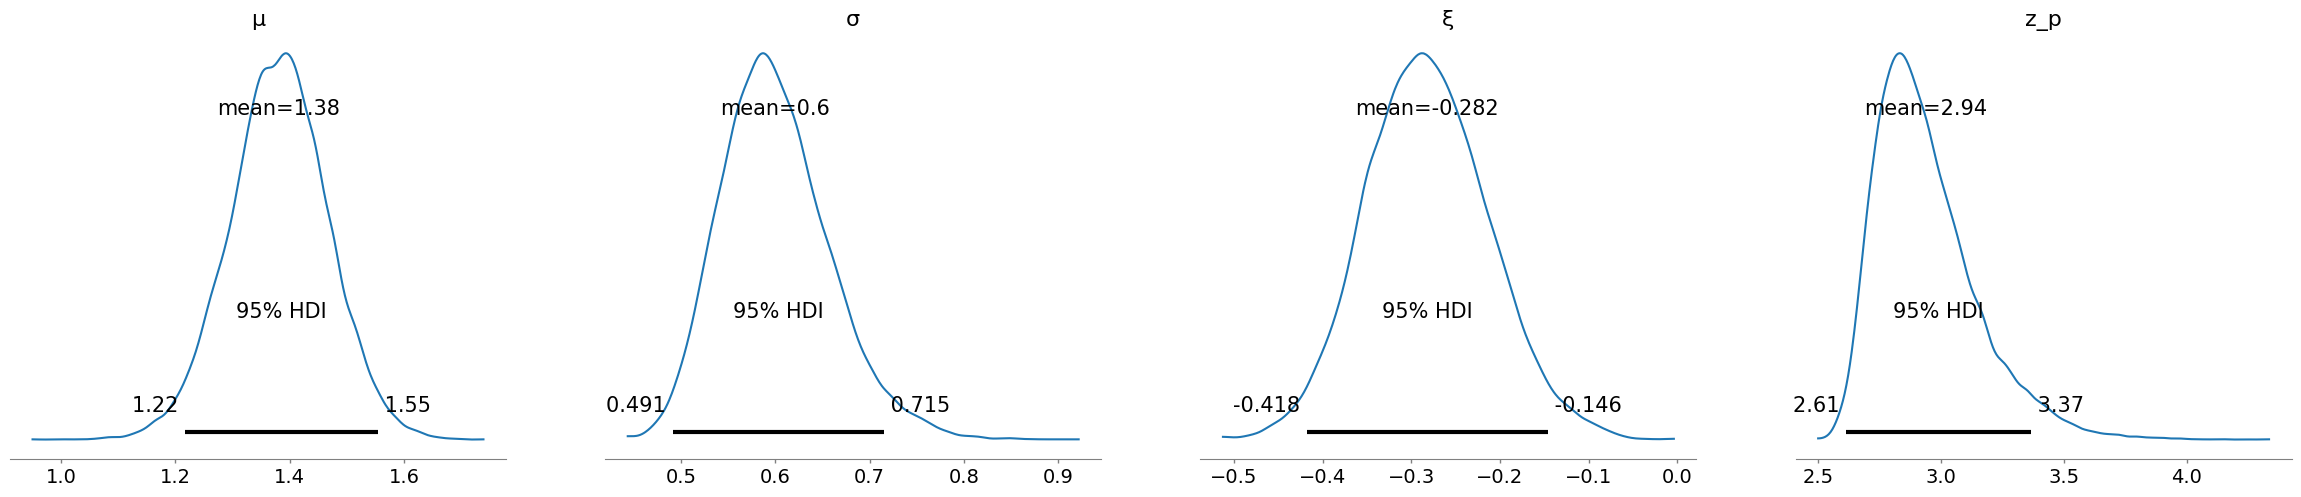

In [27]:
az.plot_posterior(idata_statio, hdi_prob=0.95, round_to=3);

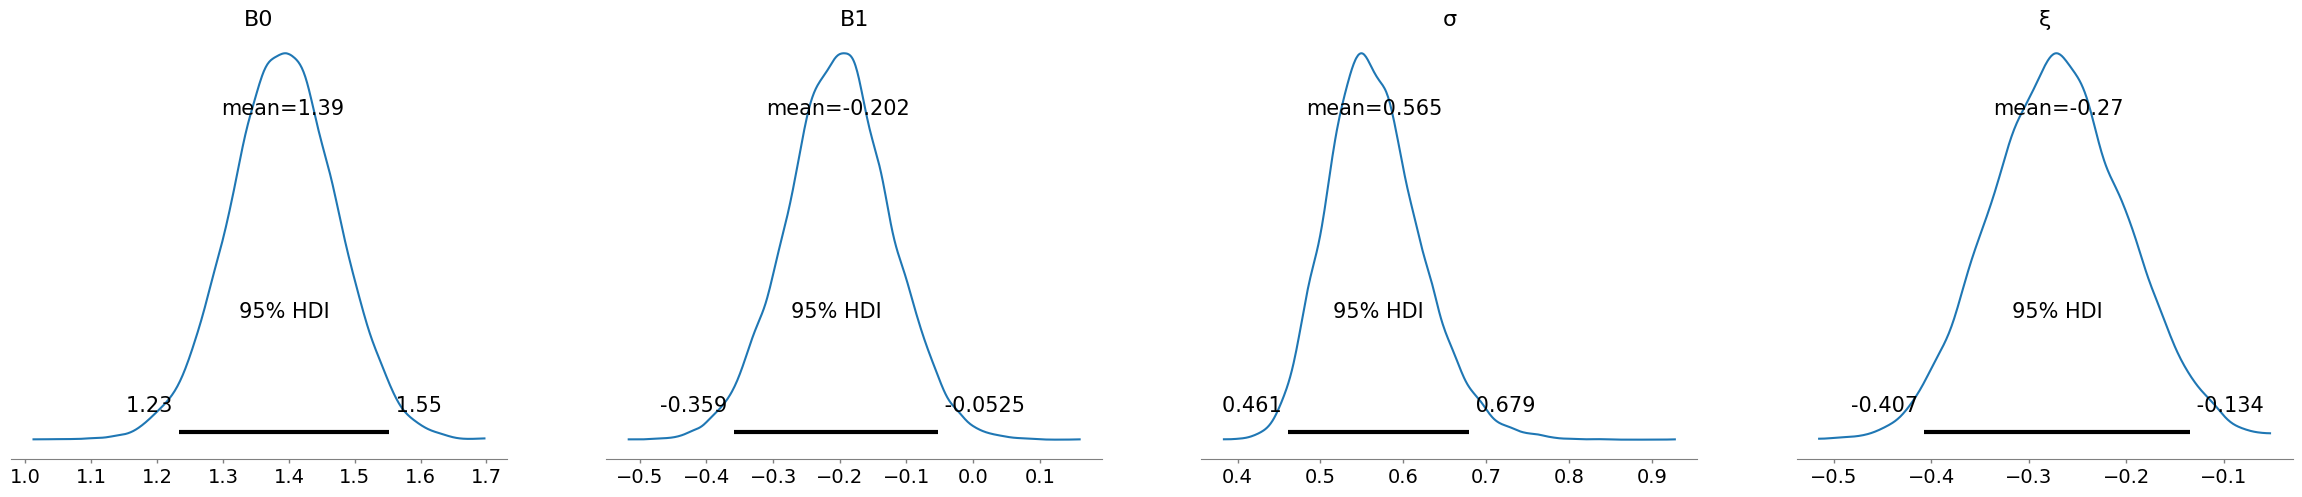

In [28]:
az.plot_posterior(idata_nostatio,var_names=["B0","B1","σ","ξ"], hdi_prob=0.95, round_to=3);

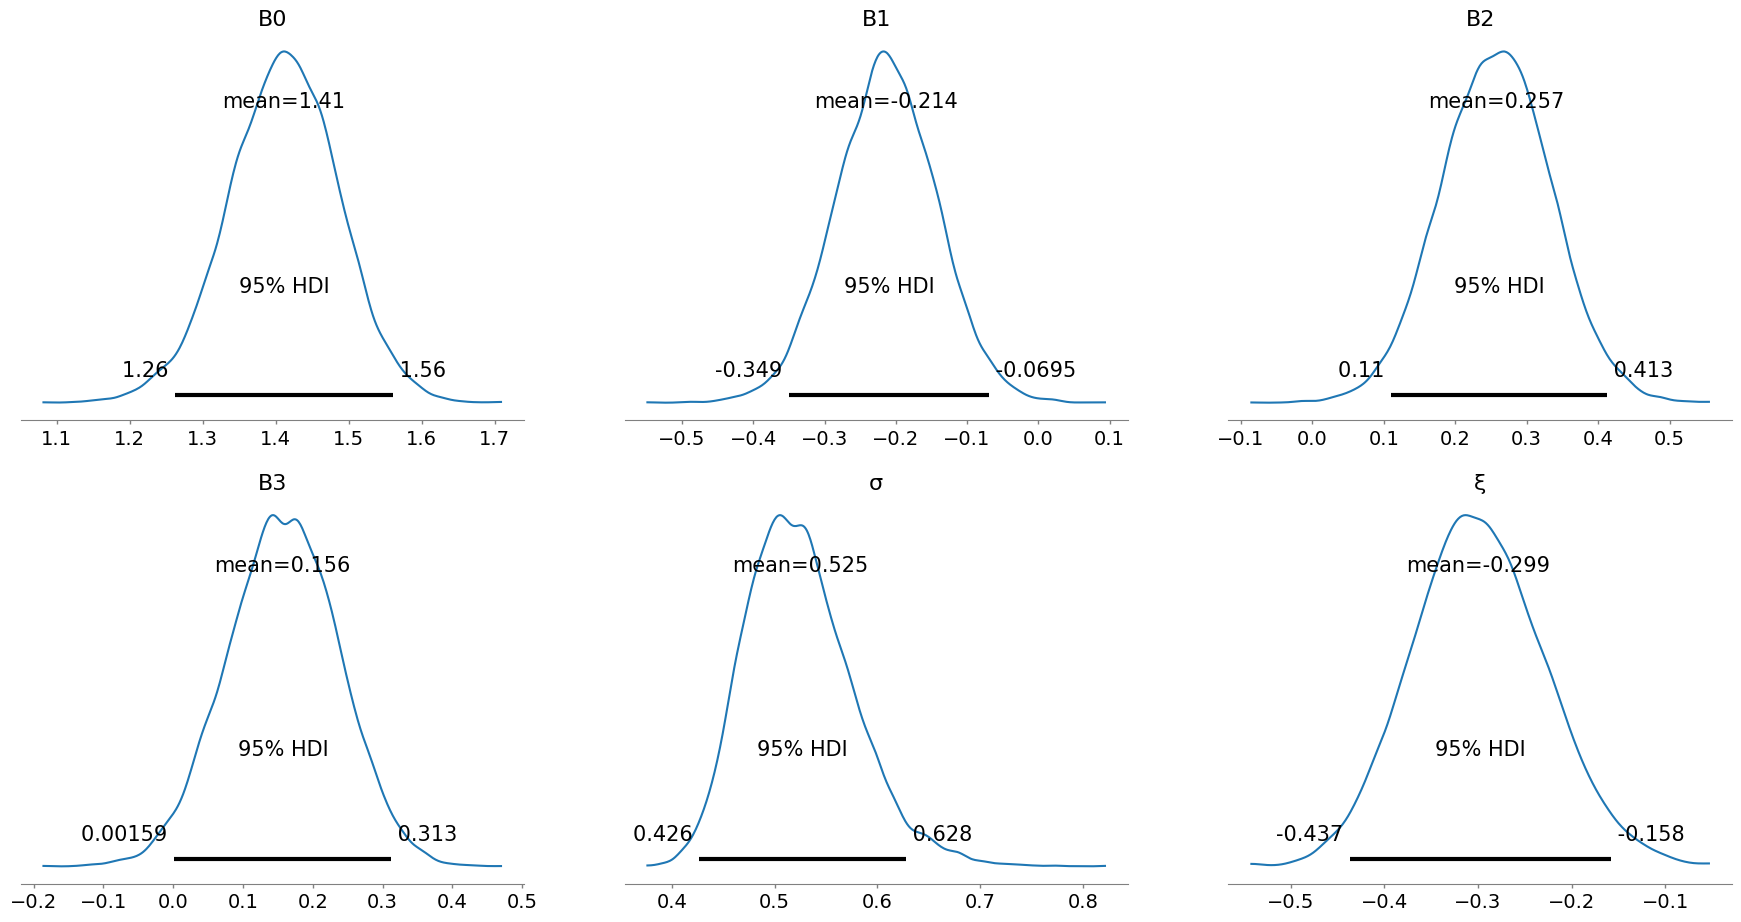

In [29]:
az.plot_posterior(idata_complex,var_names=["B0","B1","B2","B3","σ","ξ"], hdi_prob=0.95, round_to=3);

In [30]:
df_zp = idata_statio.posterior["z_p"].to_dataframe().reset_index()
df_zp_no = idata_nostatio.posterior["z_p"].to_dataframe().reset_index()
df_zp_complex = idata_complex.posterior["z_p"].to_dataframe().reset_index()

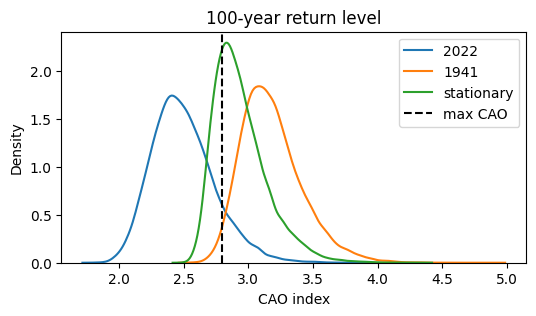

In [31]:
plt.figure(figsize=(6,3))
sns.kdeplot(df_zp_no[df_zp_no.z_p_dim_0 == 55]["z_p"], label="2022");
sns.kdeplot(df_zp_no[df_zp_no.z_p_dim_0 == 0]["z_p"], label="1941");
sns.kdeplot(df_zp["z_p"],label="stationary")
plt.axvline(np.max(y),color="black",linestyle="dashed",label="max CAO")
plt.title("100-year return level")
plt.xlabel("CAO index")
plt.legend();

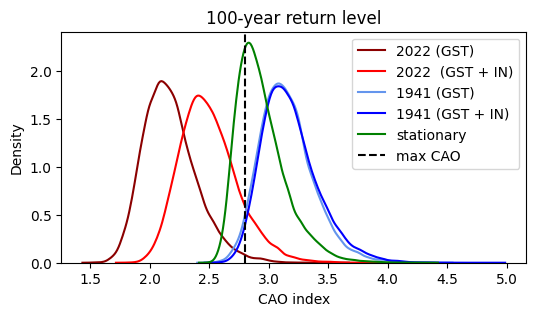

In [32]:
plt.figure(figsize=(6,3))
sns.kdeplot(df_zp_complex[df_zp_complex.z_p_dim_0 == 55]["z_p"], label="2022 (GST)",color="darkred");
sns.kdeplot(df_zp_no[df_zp_no.z_p_dim_0 == 55]["z_p"], label="2022  (GST + IN)",color="red");

sns.kdeplot(df_zp_complex[df_zp_complex.z_p_dim_0 == 0]["z_p"], label="1941 (GST)",color="cornflowerblue");
sns.kdeplot(df_zp_no[df_zp_no.z_p_dim_0 == 0]["z_p"], label="1941 (GST + IN)",color="blue");

sns.kdeplot(df_zp["z_p"],label="stationary",color="green")
plt.axvline(np.max(y),color="black",linestyle="dashed",label="max CAO")
plt.title("100-year return level")
plt.xlabel("CAO index")
plt.legend();

In [33]:
with stationary_gev:
    pm.compute_log_likelihood(idata_statio)

with no_stationary_gev:
    pm.compute_log_likelihood(idata_nostatio)

with complex_stationary_gev:
    pm.compute_log_likelihood(idata_complex)


Output()

Output()

Output()

In [34]:
az.compare({"statio": idata_statio, "nostatio": idata_nostatio, "complex": idata_complex},ic='waic')

/Users/luanbrito/Projects/bee_5850_term_project/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/luanbrito/Projects/bee_5850_term_project/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/luanbrito/Projects/bee_5850_term_project/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


rank  elpd_waic    p_waic  elpd_diff    weight        se       dse  \
complex      0 -44.517646  4.516041   0.000000  0.862354  4.505303  0.000000   
nostatio     1 -48.570661  2.854311   4.053015  0.112440  4.500804  3.408977   
statio       2 -50.924986  2.082304   6.407340  0.025206  4.762887  3.936223   

          warning scale  
complex      True   log  
nostatio     True   log  
statio       True   log

In [35]:
az.waic(idata_statio)

/Users/luanbrito/Projects/bee_5850_term_project/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 20000 posterior samples and 56 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -50.92     4.76
p_waic        2.08        -

There has been a warning during the calculation. Please check the results.

# Older implementation below, useful functions

There are different approaches to estimate the empirical return levels and return periods, below a comparison of the three methodos (Gringorten, Weibull and Cunnane)

In [36]:
var = 'cao_index_max'

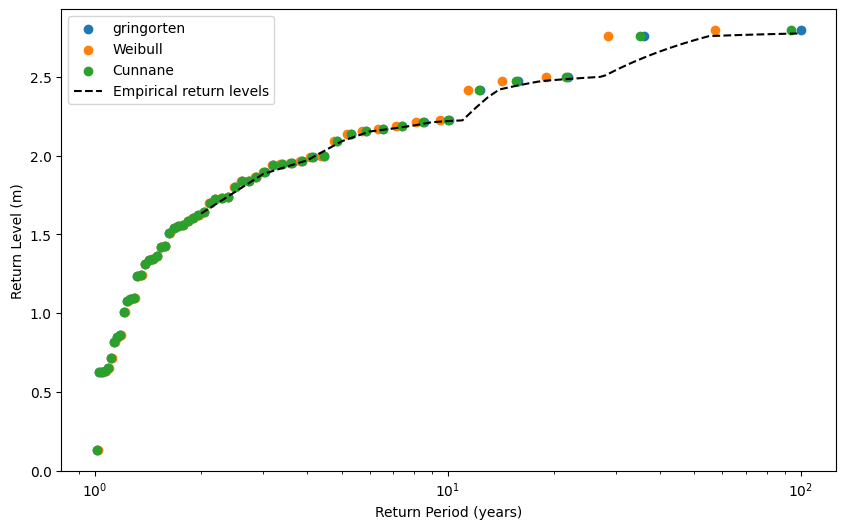

In [37]:
def gringorten(i, n):
    return (i - 0.44) / (n + 0.12)

def Weibull(i, n):
    return i/(n+1) 

def Cunnane(i,n):
    return (i - 0.4)/(n + 0.2)

#Empirical return periods
return_periods = np.array(list(range(2,101)))
return_levels_obs = np.quantile(dat[var],1-1/return_periods)

sorted_data = np.sort(dat[var])
n = len(sorted_data)

pp_gringorten = np.array([gringorten(i+1, n) for i in range(n)])
pp_Weibull = np.array([Weibull(i+1, n) for i in range(n)])
pp_Cunnane = np.array([Cunnane(i+1, n) for i in range(n)])

gringorten_return_periods = 1 / (1 - pp_gringorten)
Weibull_return_periods = 1 / (1 - pp_Weibull)
Cunnane_return_periods = 1 / (1 - pp_Cunnane)

plt.figure(figsize=(10, 6))
plt.scatter(gringorten_return_periods, sorted_data, marker='o', label='gringorten')
plt.scatter(Weibull_return_periods, sorted_data, marker='o', label='Weibull')
plt.scatter(Cunnane_return_periods, sorted_data, marker='o', label='Cunnane')
plt.plot(return_periods, return_levels_obs,color='black', label='Empirical return levels',linestyle='dashed')
plt.xscale('log')  
plt.xlabel('Return Period (years)')
plt.ylabel('Return Level (m)')
plt.legend()
plt.show()


### Stationary GEV

In [38]:
#Fit GEV using the scipy genextreme function
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genextreme.html
gev_params = genextreme.fit(dat[var])
print(np.round(gev_params,4))

xi = -gev_params[0]
mu = gev_params[1]
sigma = gev_params[2]

[0.3612 1.4163 0.5997]


`scipy.genextreme` returns the GEV fitted parameters in the order ($-\xi$,$\mu$,$\sigma$)

| $\mu$  |  $\sigma$ | $\xi$  |
|---|---|---|
| 1.3314  | 0.5782  | -0.3281  |

ps: table generated by [https://www.tablesgenerator.com/markdown_tables](https://www.tablesgenerator.com/markdown_tables)

In [39]:
gev_fit = genextreme(*gev_params)

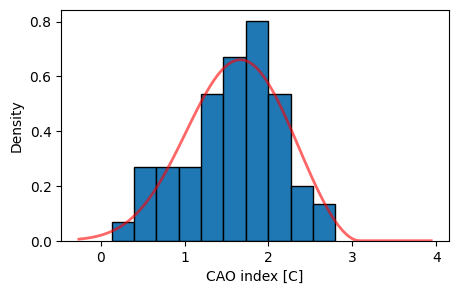

In [40]:
x = np.linspace(gev_fit.ppf(0.001),gev_fit.ppf(0.999)+1, 100)

plt.figure(figsize=(5,3))
plt.hist(dat[var],density=True,edgecolor='black')
plt.plot(x, gev_fit.pdf(x),'r-', lw=2, alpha=0.6, label='genextreme pdf')
plt.xlabel("CAO index [C]")
plt.ylabel("Density")
plt.show()

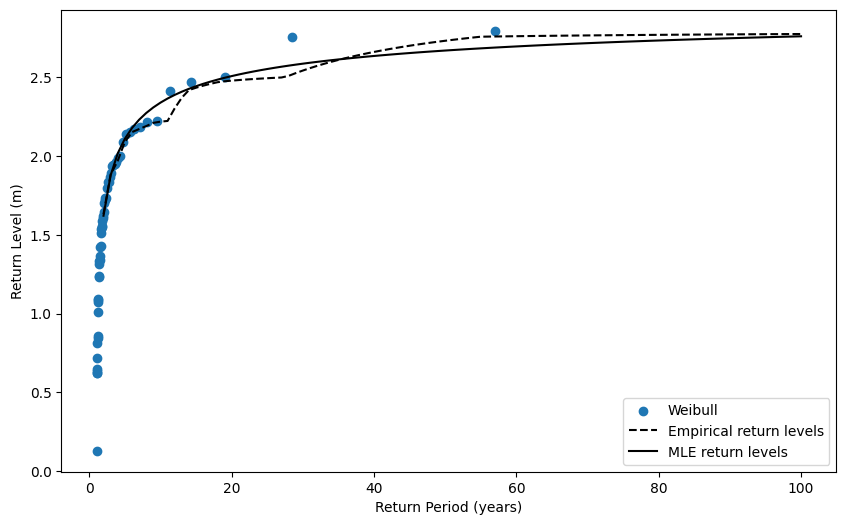

In [41]:
mle_return_levels = gev_fit.ppf(1-1/return_periods)

plt.figure(figsize=(10, 6))
#plt.scatter(gringorten_return_periods, sorted_data, marker='o', label='gringorten',s=15)
plt.scatter(Weibull_return_periods, sorted_data, marker='o', label='Weibull')
#plt.scatter(Cunnane_return_periods, sorted_data, marker='o', label='Cunnane',s=5)
plt.plot(return_periods, return_levels_obs,color='black', label='Empirical return levels',linestyle='dashed')
plt.plot(return_periods, mle_return_levels,color='black', label='MLE return levels')
#plt.xscale('log')  
plt.xlabel('Return Period (years)')
plt.ylabel('Return Level (m)')
plt.legend()
plt.show()

### Bayesian stationary model

In [42]:
# Optionally centre the data, depending on fitting and divergences
# cdata = (data - data.mean())/data.std()

#p = 1/10
y = np.array(dat[var])

with pm.Model() as model:
    # Priors
#    μ = pm.Normal("μ", mu=0, sigma=10000)
#    σ = pm.Normal("σ", mu=0, sigma=10000)
#    ξ = pm.Normal("ξ", mu=0, sigma=100)

    μ = pm.Normal("μ",  mu=0,sigma=2.5)
    σ = pm.HalfNormal("σ", sigma=5)
    ξ = pm.TruncatedNormal("ξ", mu=-0.2, sigma=0.1, lower=-0.6, upper=0.1)

    # Estimation
    gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ, observed=y)
    # Return level
    #z_p = pm.Deterministic("z_p", μ - σ / ξ * (1 - (-np.log(1 - p)) ** (-ξ)))

Prior predictive check

In [43]:
idata = pm.sample_prior_predictive(samples=1000, model=model)

Sampling: [gev, μ, ξ, σ]


Prior predictive check

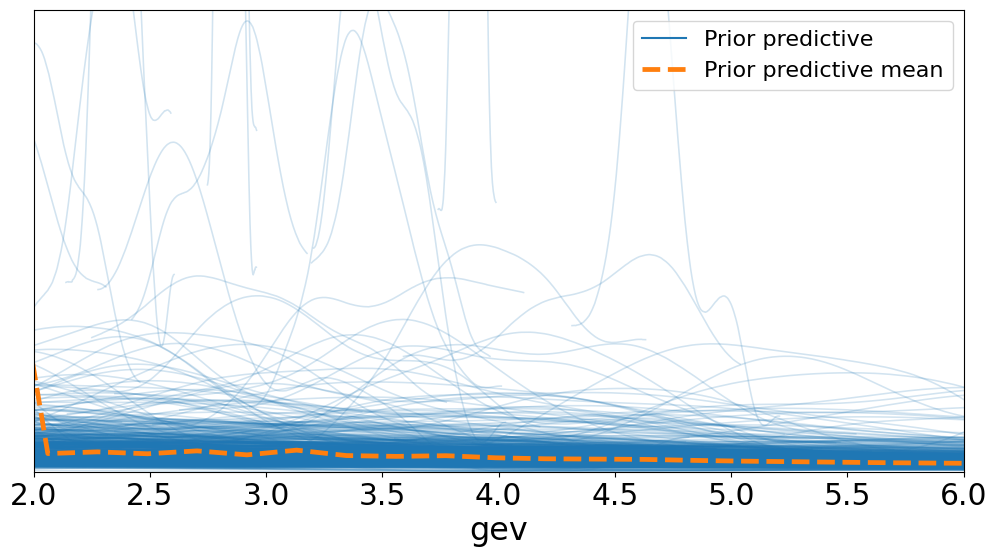

In [44]:
az.plot_ppc(idata, group="prior", figsize=(12, 6))
ax = plt.gca()
ax.set_xlim([2, 6])
ax.set_ylim([0, 2]);

Prior distributions

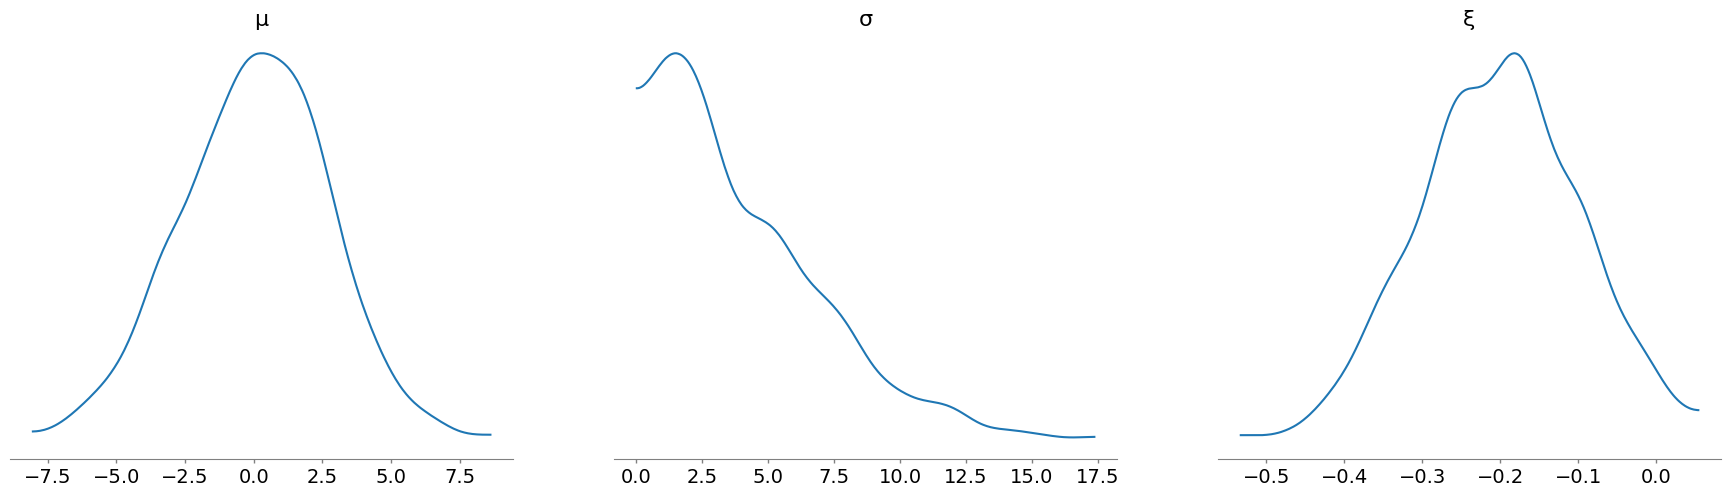

In [45]:
az.plot_posterior(
    idata, group="prior", var_names=["μ", "σ", "ξ"], hdi_prob="hide", point_estimate=None
);

In [46]:
with model:
    trace = pm.sample(
        5000,
        cores=4,
        chains=4,
        tune=2000,
        initvals={"μ": 0, "σ": 1, "ξ": -0.1},
        target_accept=0.98,
        progressbar = True
    )
# add trace to existing idata object
idata.extend(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ξ]


Output()

Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 5 seconds.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.


In [47]:
model.debug()

point={'μ': array(0.), 'σ_log__': array(1.60943791), 'ξ_interval__': array(0.)}

No problems found


Check chains convergence

In [48]:
az.summary(trace).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
μ  1.38  0.08    1.23     1.54        0.0      0.0   11177.0   11310.0    1.0
σ  0.60  0.06    0.49     0.71        0.0      0.0   10659.0   10638.0    1.0
ξ -0.28  0.07   -0.41    -0.15        0.0      0.0    9271.0    8805.0    1.0

In [49]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [gev]


Output()

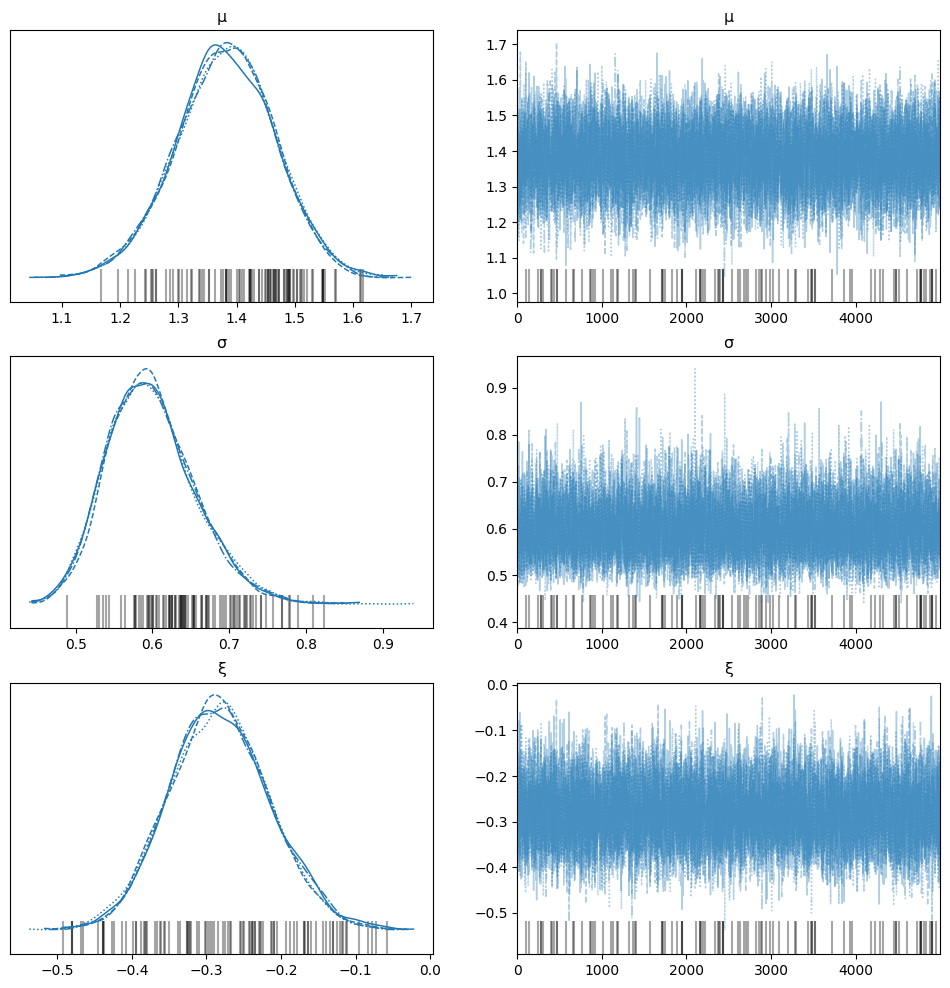

In [50]:
az.plot_trace(idata, var_names=["μ", "σ", "ξ"], figsize=(12, 12));

In [51]:
df_samples = idata["posterior"].to_dataframe().reset_index()
df_samples = df_samples[df_samples.chain==0] #Selected samples from one of the chains
df_samples.head(5)

chain  draw         μ         σ         ξ
0      0     0  1.366329  0.627697 -0.247845
1      0     1  1.456255  0.586864 -0.313804
2      0     2  1.370696  0.581897 -0.269355
3      0     3  1.406445  0.579787 -0.316671
4      0     4  1.403812  0.578249 -0.316445

In [52]:
az.hdi(idata, hdi_prob=0.95)

<xarray.Dataset> Size: 96B
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 48B 'lower' 'higher'
Data variables:
    μ        (hdi) float64 16B 1.217 1.55
    σ        (hdi) float64 16B 0.4928 0.715
    ξ        (hdi) float64 16B -0.4046 -0.1412

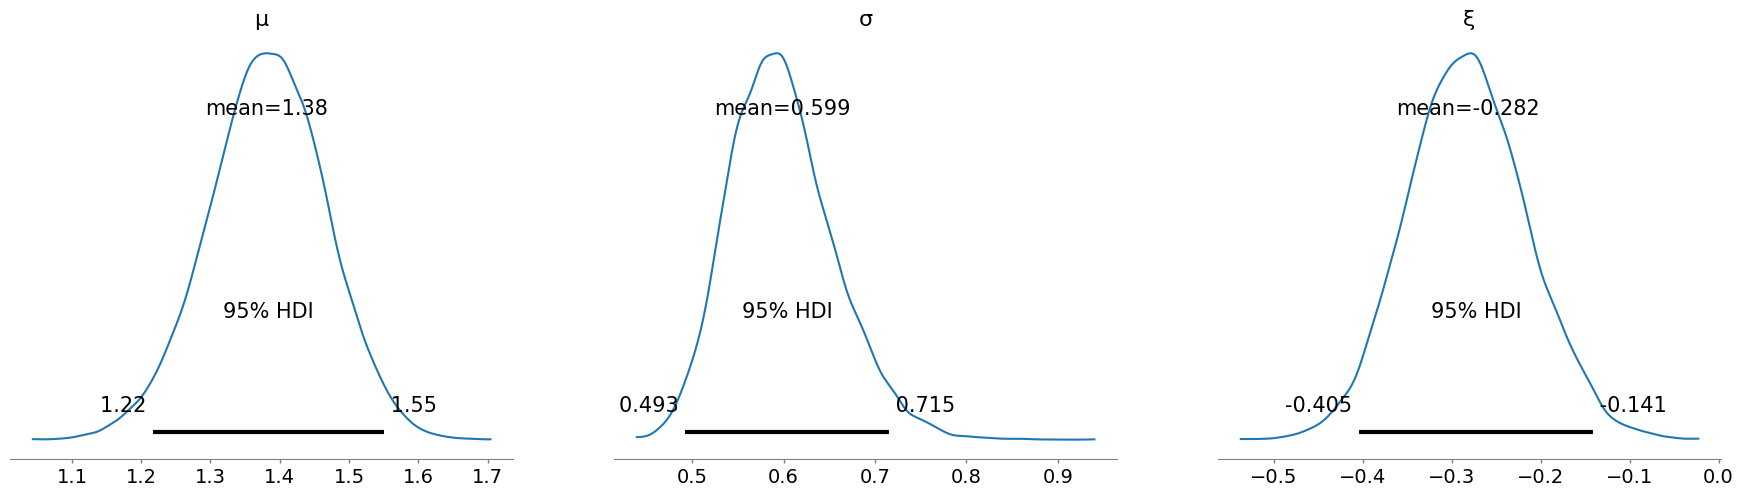

In [53]:
az.plot_posterior(idata, hdi_prob=0.95, round_to=3);

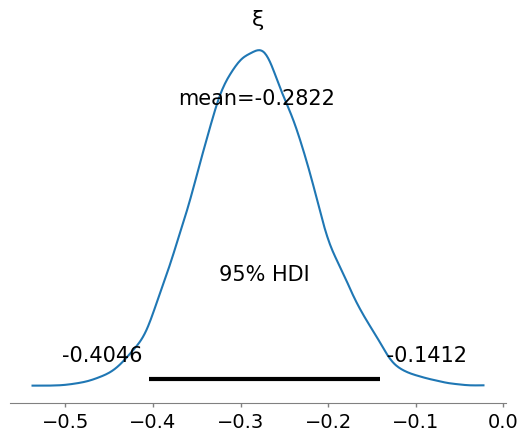

In [54]:
az.plot_posterior(idata, hdi_prob=0.95, var_names=["ξ"], round_to=4);

In [55]:
_, vals = az.sel_utils.xarray_to_ndarray(idata["posterior"], var_names=["μ", "σ", "ξ"])

[azpu.calculate_point_estimate("mean", val) for val in vals]

[np.float64(1.381275450703696),
 np.float64(0.5985483036205345),
 np.float64(-0.2821883628564623)]

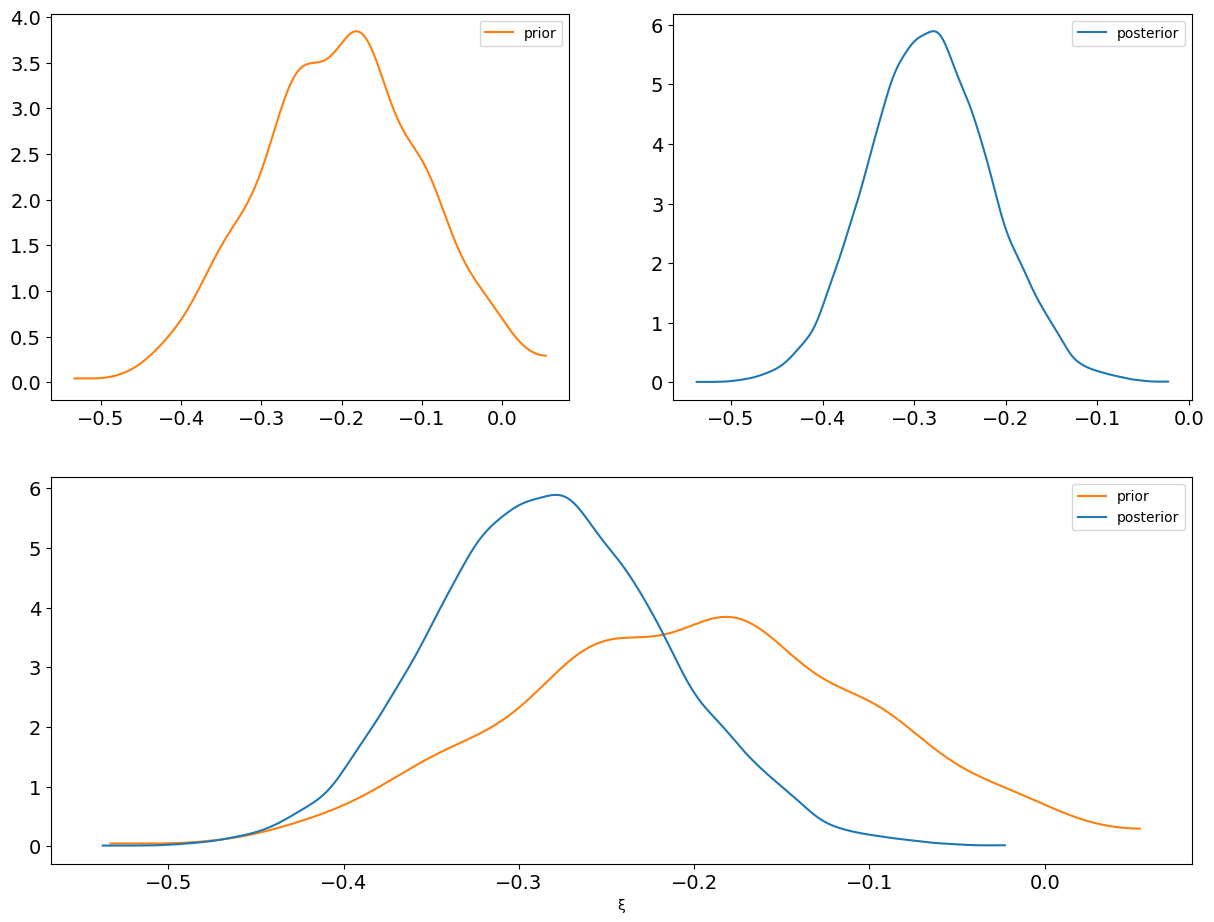

In [56]:
az.plot_dist_comparison(idata, var_names=["ξ"]);

In [57]:
idata["posterior"].to_dataframe().cov().round(6)

μ         σ         ξ
μ  0.007166 -0.000727 -0.001445
σ -0.000727  0.003301 -0.001182
ξ -0.001445 -0.001182  0.004559

In [58]:
df_samples = idata["posterior"].to_dataframe().reset_index()
df_samples = df_samples[df_samples.chain==0] #Selected samples from one of the chains
df_samples.head(5)

chain  draw         μ         σ         ξ
0      0     0  1.366329  0.627697 -0.247845
1      0     1  1.456255  0.586864 -0.313804
2      0     2  1.370696  0.581897 -0.269355
3      0     3  1.406445  0.579787 -0.316671
4      0     4  1.403812  0.578249 -0.316445

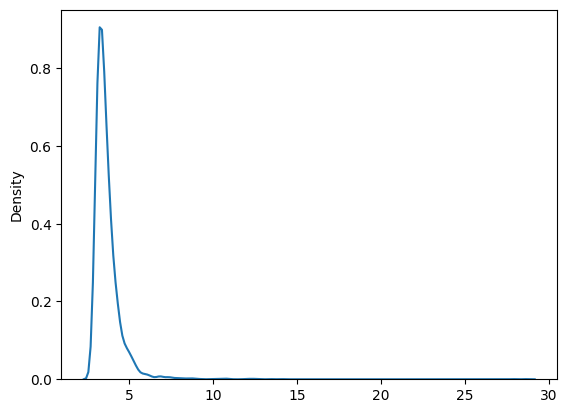

In [59]:
upper_bound = df_samples["μ"] - df_samples["σ"]/df_samples["ξ"]
sns.kdeplot(upper_bound, label="Seaborn KDE");

In [60]:
return_levels_samples = np.zeros((np.shape(df_samples)[0],np.size(return_periods)))

for idx in range(0,np.shape(df_samples)[0]):
    mu_sample = df_samples["μ"][idx]
    sigma_sample= df_samples["σ"][idx]
    xi_sample = df_samples["ξ"][idx]
    params = np.array([-xi_sample,mu_sample,sigma_sample])
    sample_gev = genextreme(*params)
    return_levels_samples[idx,:] = sample_gev.ppf(1-1/return_periods)

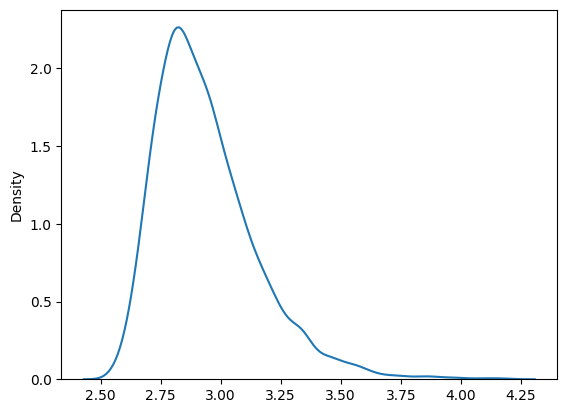

In [61]:
sns.kdeplot(return_levels_samples[:,-1], label="Seaborn KDE");

In [62]:
rl_bay_q = np.quantile(return_levels_samples, [0.025, 0.5, 0.975], axis=0)

In [63]:
points = np.array([np.column_stack([return_periods, y]) for y in return_levels_samples])

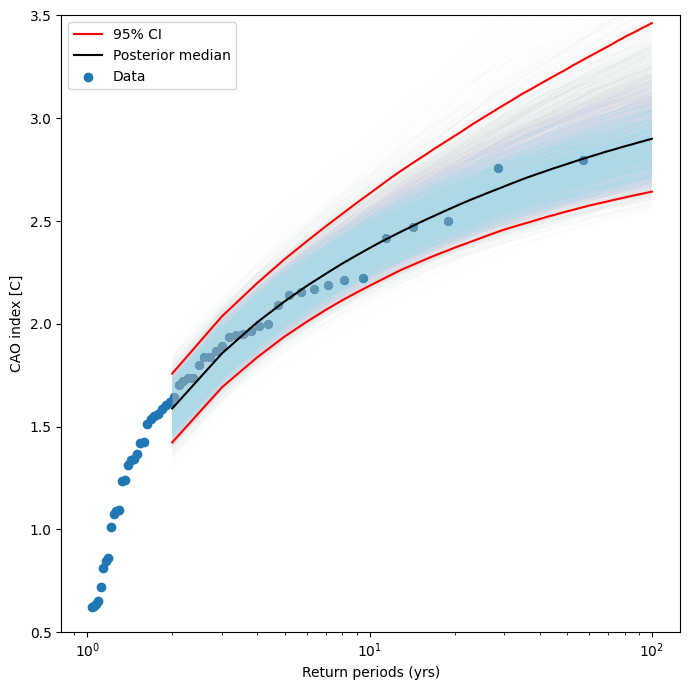

In [64]:
fig, ax = plt.subplots(figsize=(7, 7))
line_segments = LineCollection(points, 
alpha=0.02,  # Low alpha for better visualization
linewidth=0.5,
color='lightblue')
ax.add_collection(line_segments)
ax.plot(return_periods,rl_bay_q[0],color='red',label='95% CI')
ax.plot(return_periods,rl_bay_q[1],color='black',label='Posterior median')
ax.plot(return_periods,rl_bay_q[2],color='red')
ax.scatter(Weibull_return_periods, sorted_data, marker='o', label='Data')
ax.autoscale()
ax.set_xlabel('Return periods (yrs)')
ax.set_ylabel('CAO index [C]')
ax.set_xticks(np.array([0,1,2,3]), labels=[1,10,100,1000])
plt.xscale('log')  
plt.ylim(0.5,3.5)
plt.tight_layout()
plt.legend();

In [65]:
y_fit = idata.posterior_predictive['gev'].mean(("chain", "draw")).values


In [66]:
_, vals = az.sel_utils.xarray_to_ndarray(idata["posterior"])

sigma = [azpu.calculate_point_estimate("median", val) for val in vals][1]

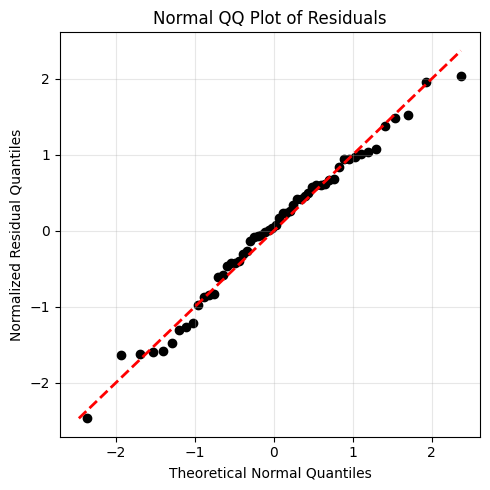

In [67]:
#QQ plot
residuals = y.ravel() - y_fit.ravel()  # Use residuals for QQ plot, not raw y values
sample_quantiles = np.sort(residuals)
n = len(sample_quantiles)
probs = (np.arange(1, n+1) - 0.5) / n
theoretical_quantiles = norm.ppf(probs, loc=0, scale=1)  # Standard normal quantiles

min_val = min(theoretical_quantiles.min(), (sample_quantiles/sigma).min())
max_val = max(theoretical_quantiles.max(), (sample_quantiles/sigma).max())

plt.figure(figsize=(5,5))
plt.scatter(theoretical_quantiles, sample_quantiles/sigma, color='black')
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
plt.title("Normal QQ Plot of Residuals")
plt.ylabel("Normalized Residual Quantiles")
plt.xlabel("Theoretical Normal Quantiles")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Non-stationary GEV

In [68]:
def gev_ll(params, _x, _y):
    B0, B1, scale, shape = params
    
    # Check scale constraint
    if scale <= 0:
        return np.inf
        
    # Calculate time-varying location
    location = B0 + B1 * _y
    
    # Calculate standardized values
    z = (_x - location) / scale
    
    # Calculate transformed variable tx with higher-order expansion
    tx = np.zeros_like(z)
    
    if abs(shape) < 1e-10:  # Expansion near zero
        tx = -z + (z**2) * shape / 2 - (z**3) * (shape**2) / 3 + (z**4) * (shape**3) / 4
    else:
        # Check domain constraints before log computation
        term = 1 + shape * z
        if np.any(term <= 0):
            return np.inf
        tx = (-1 / shape) * np.log(term)
    
    # Calculate log-likelihood
    ll = (shape + 1) * tx - np.exp(tx) - np.log(scale)
    
    return -np.sum(ll)

In [69]:
initial_params = [1.43955, -0.358997 ,0.55584, -0.309772]
bounds = [(-5, 5), (-5, 5), (1e-5, 10), (-2, 2)]
bounds = [(None, None), (None, None), (1e-6, 10), (-2, 2)]

result = minimize(gev_ll,x0 = initial_params, args=(np.array(dat[var]),np.array(dat["GSTM"])),method='L-BFGS-B',bounds=bounds)

In [70]:
result.x

array([ 1.66787259, -0.64459943,  0.5599784 , -0.34699325])

In [71]:
mu = result.x[0] + result.x[1] * dat["GSTM"]
p = 1/100
y = -np.log(1-p)
z_gstm = mu - result.x[2]/result.x[3] * (1 - (y)**(-result.x[3]))

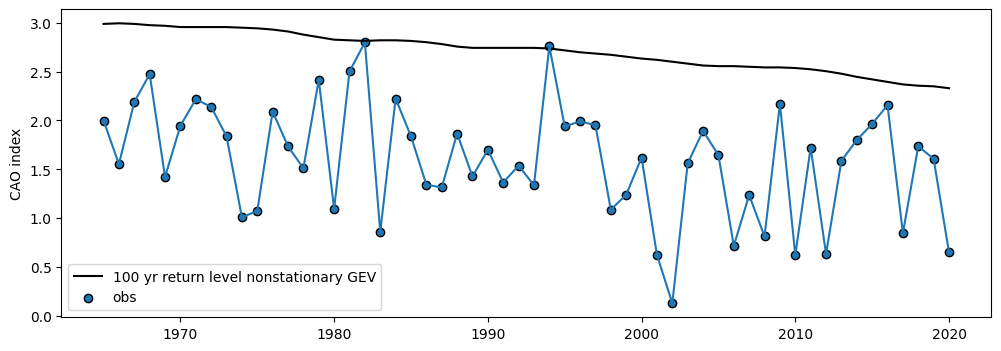

In [72]:
plt.figure(figsize=(12,4))
plt.plot(np.array(dat['year']),z_gstm,color="black",label="100 yr return level nonstationary GEV")
plt.plot(np.array(dat['year']),np.array(dat[var]),c="#1f77b4")
plt.scatter(np.array(dat['year']),np.array(dat[var]),c="#1f77b4",edgecolors='black',label="obs")
plt.ylabel("CAO index")
plt.legend()
plt.show()

In [73]:
# Optionally centre the data, depending on fitting and divergences
# cdata = (data - data.mean())/data.std()

#p = 1/10
y = np.array(dat[var])
x = np.array(dat['GSTM'])

with pm.Model() as model:
    # Priors
#    μ = pm.Normal("μ", mu=0, sigma=10000)
#    σ = pm.Normal("σ", mu=0, sigma=10000)
#    ξ = pm.Normal("ξ", mu=0, sigma=100)

    B0 = pm.Normal("B0",  mu=0,sigma=5)
    B1 = pm.Normal("B1",  mu=0,sigma=5)
    μ = B0 + B1 * x
    σ = pm.HalfNormal("σ", sigma=5)
    ξ = pm.TruncatedNormal("ξ", mu=-0.2, sigma=0.1, lower=-0.6, upper=-0.05)

    # Estimation
    gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ, observed=y)
    # Return level
    #z_p = pm.Deterministic("z_p", μ - σ / ξ * (1 - (-np.log(1 - p)) ** (-ξ)))

In [74]:
idata = pm.sample_prior_predictive(samples=1000, model=model)

Sampling: [B0, B1, gev, ξ, σ]


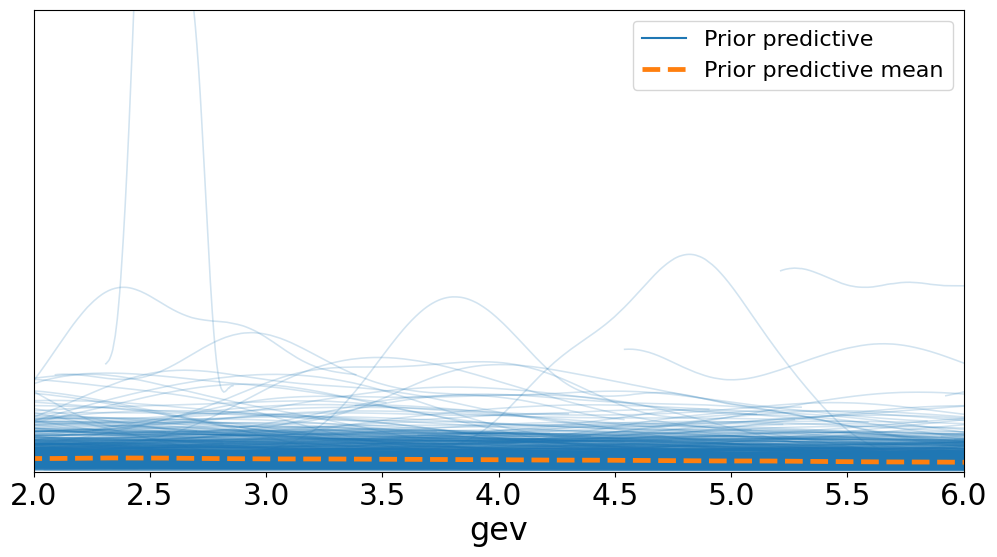

In [75]:
az.plot_ppc(idata, group="prior", figsize=(12, 6))
ax = plt.gca()
ax.set_xlim([2, 6])
ax.set_ylim([0, 2]);

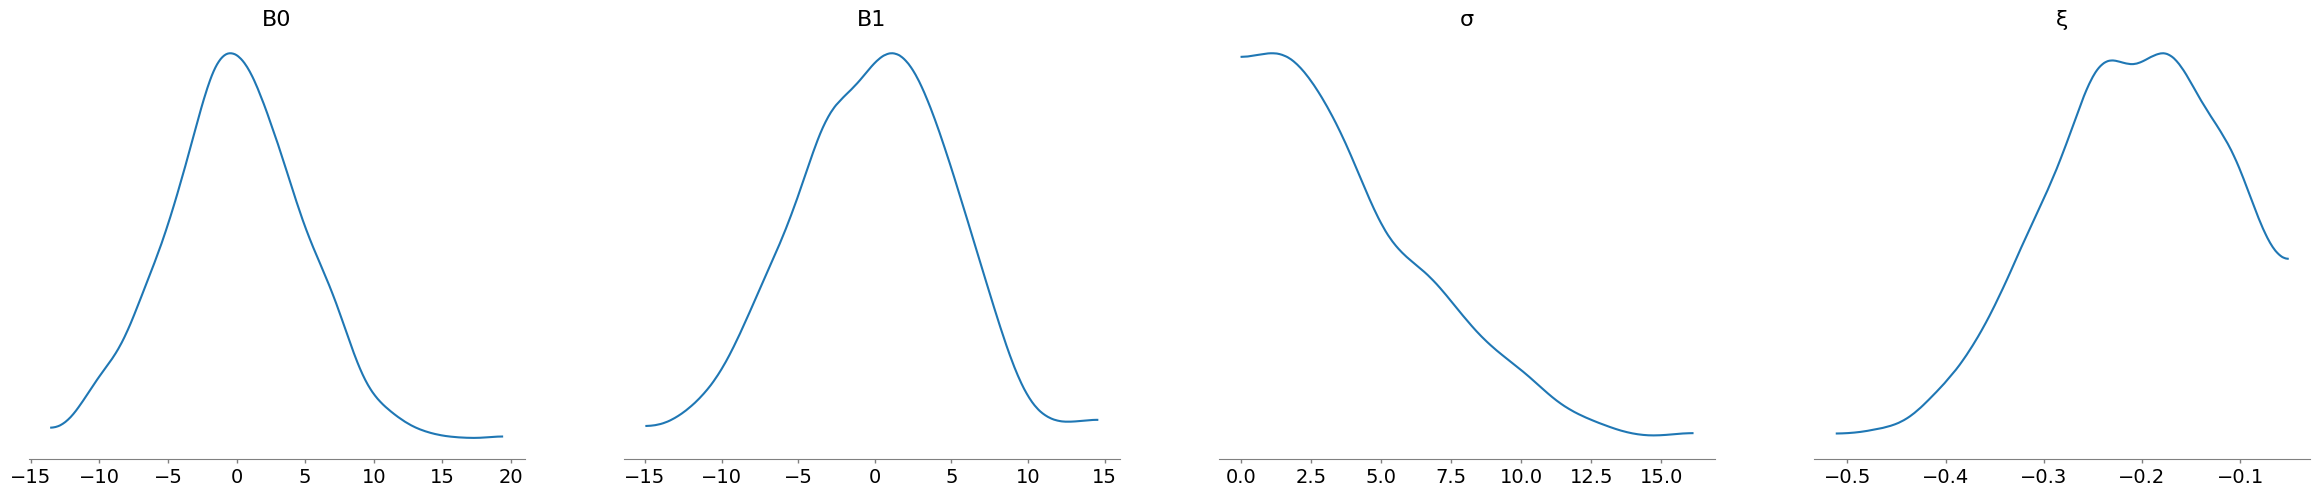

In [76]:
az.plot_posterior(
    idata, group="prior", var_names=["B0", "B1", "σ", "ξ"], hdi_prob="hide", point_estimate=None
);

In [77]:
with model:
    trace = pm.sample(
        5000,
        cores=4,
        chains=4,
        tune=2000,
        initvals={"B0": 0,"B1": 0, "σ": 1, "ξ": -0.1},
        target_accept=0.98,
        progressbar = True
    )
# add trace to existing idata object
idata.extend(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [B0, B1, σ, ξ]


Output()

Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 6 seconds.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.


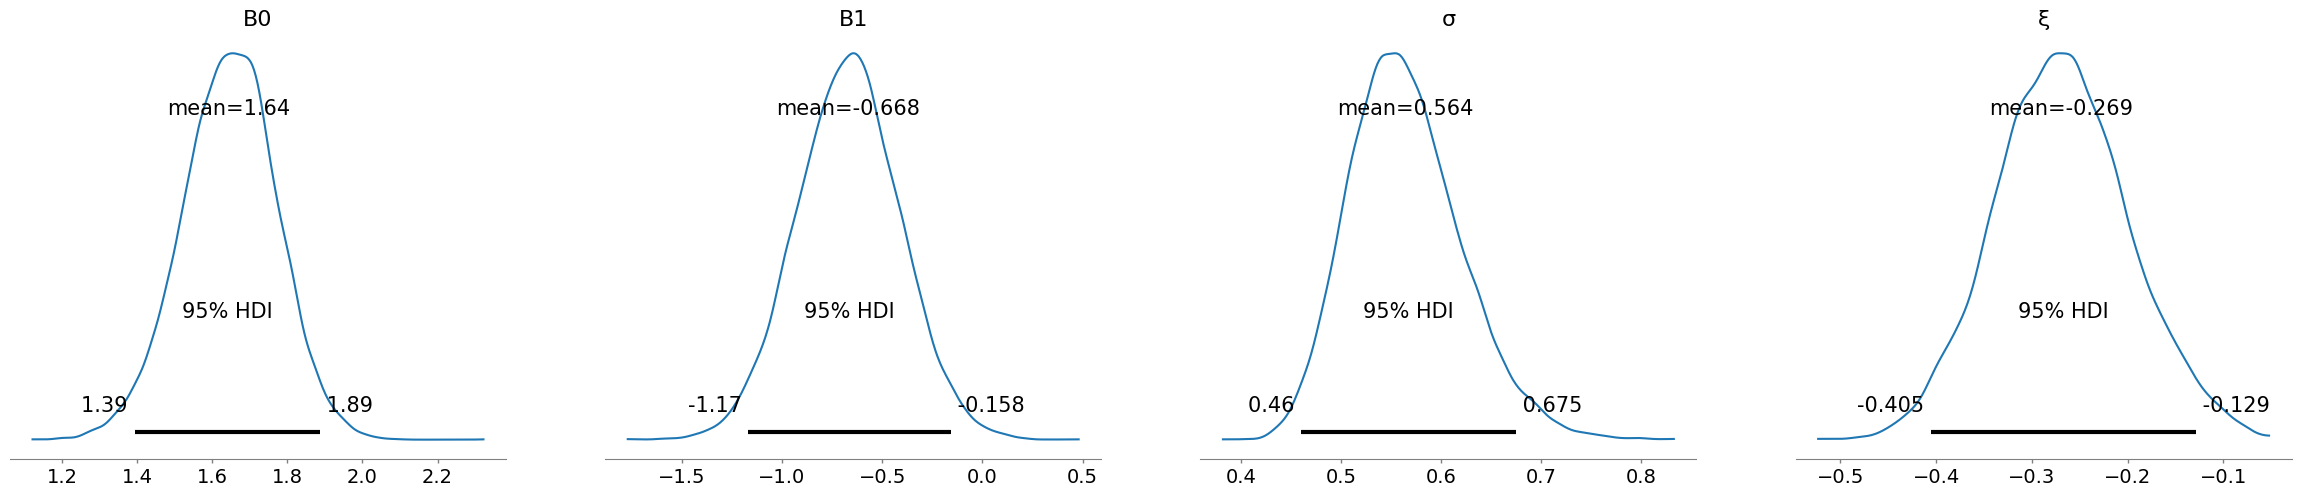

In [78]:
az.plot_posterior(idata, hdi_prob=0.95, round_to=3);

In [79]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [gev]


Output()

In [80]:
az.summary(trace).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
B0  1.64  0.12    1.41     1.88        0.0      0.0    7620.0   10015.0    1.0
B1 -0.67  0.26   -1.16    -0.19        0.0      0.0    7770.0    9681.0    1.0
σ   0.56  0.06    0.46     0.67        0.0      0.0   11125.0   11229.0    1.0
ξ  -0.27  0.07   -0.40    -0.14        0.0      0.0   10240.0    7958.0    1.0

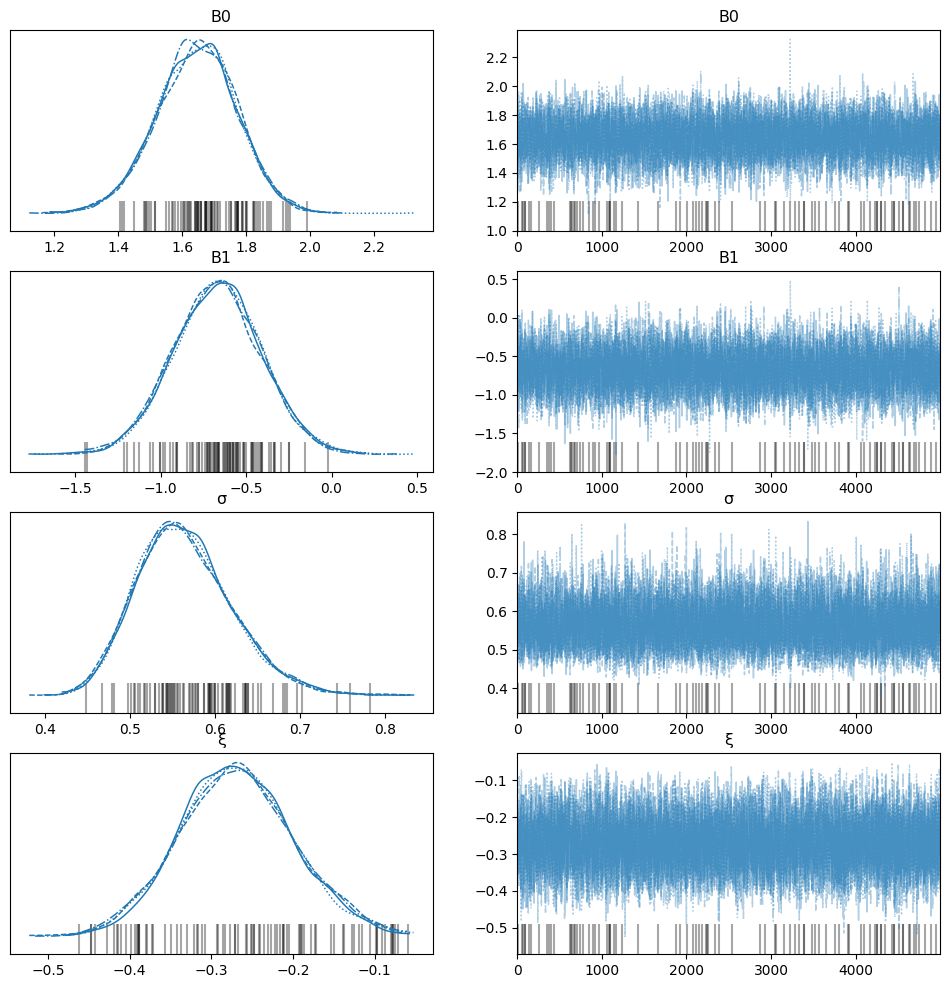

In [81]:
az.plot_trace(idata, var_names=["B0","B1", "σ", "ξ"], figsize=(12, 12));

In [82]:
df_samples = idata["posterior"].to_dataframe().reset_index()
df_samples = df_samples[df_samples.chain==0] #Selected samples from one of the chains
df_samples.head(5)

chain  draw        B0        B1         σ         ξ
0      0     0  1.610755 -0.730418  0.508930 -0.310650
1      0     1  1.774394 -0.709118  0.509965 -0.242387
2      0     2  1.640166 -0.786308  0.558333 -0.195344
3      0     3  1.629676 -0.446597  0.609979 -0.250933
4      0     4  1.504205 -0.568543  0.615812 -0.293653

In [83]:
return_levels_1941 = np.zeros(np.shape(df_samples)[0])
return_levels_2022 = np.zeros(np.shape(df_samples)[0])

for idx in range(0,np.shape(df_samples)[0]):
    mu_sample_1941 = df_samples["B0"][idx] + df_samples["B1"][idx]*dat.loc[dat['year']==1941,'GSTM'].values[0]
    mu_sample_2022 = df_samples["B0"][idx] + df_samples["B1"][idx]*dat.loc[dat['year']==2022,'GSTM'].values[0]
    #mu_sample = df_samples["μ"][idx]
    sigma_sample= df_samples["σ"][idx]
    xi_sample = df_samples["ξ"][idx]
    params_1941 = np.array([-xi_sample,mu_sample_1941,sigma_sample])
    params_2022  = np.array([-xi_sample,mu_sample_2022,sigma_sample])

    sample_gev_1941  = genextreme(*params_1941)
    sample_gev_2022  = genextreme(*params_2022)

    return_levels_1941[idx] = sample_gev_1941.ppf(1-1/100)
    return_levels_2022[idx] = sample_gev_2022.ppf(1-1/100)

IndexError: index 0 is out of bounds for axis 0 with size 0

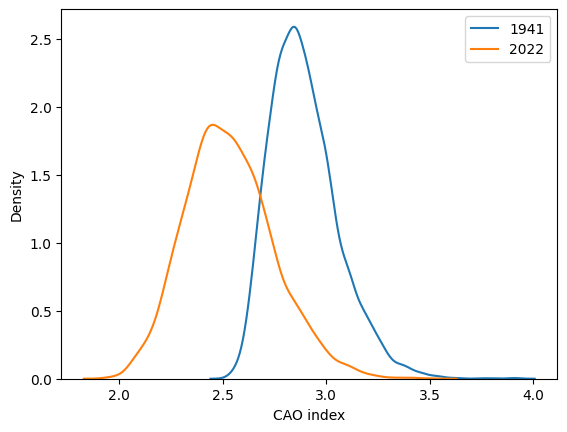

In [ ]:
sns.kdeplot(return_levels_1941, label="1941");
sns.kdeplot(return_levels_2022, label="2022");
plt.xlabel("CAO index")
plt.legend()

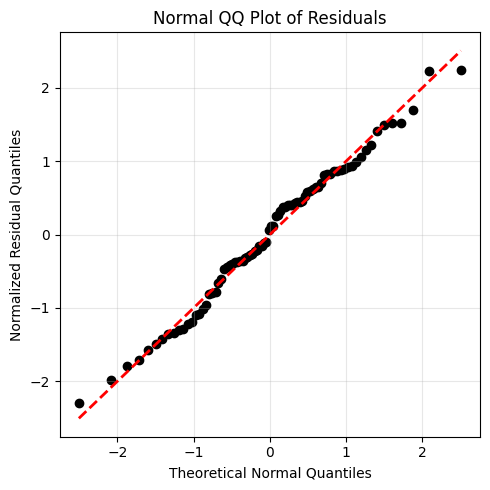

In [ ]:

y_fit = idata.posterior_predictive['gev'].mean(("chain", "draw")).values


_, vals = az.sel_utils.xarray_to_ndarray(idata["posterior"])

sigma = [azpu.calculate_point_estimate("median", val) for val in vals][2]

#QQ plot
residuals = y.ravel() - y_fit.ravel()  # Use residuals for QQ plot, not raw y values
sample_quantiles = np.sort(residuals)
n = len(sample_quantiles)
probs = (np.arange(1, n+1) - 0.5) / n
theoretical_quantiles = norm.ppf(probs, loc=0, scale=1)  # Standard normal quantiles

min_val = min(theoretical_quantiles.min(), (sample_quantiles/sigma).min())
max_val = max(theoretical_quantiles.max(), (sample_quantiles/sigma).max())

plt.figure(figsize=(5,5))
plt.scatter(theoretical_quantiles, sample_quantiles/sigma, color='black')
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
plt.title("Normal QQ Plot of Residuals")
plt.ylabel("Normalized Residual Quantiles")
plt.xlabel("Theoretical Normal Quantiles")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Non-stationary GEV + AM + IPO

In [ ]:
dat_nona = dat.dropna()
#(dat_nona - dat_nona.mean())/dat_nona.std()
dat_nona
for d in ['cao_index_max','GSTM','IPO','AM']:
    dat_nona[d] = (dat_nona[d] - dat_nona[d].mean())/dat_nona[d].std()

/var/folders/y7/411dcnwj4853mcwpgyz634_m0000gn/T/ipykernel_901/738537376.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_nona[d] = (dat_nona[d] - dat_nona[d].mean())/dat_nona[d].std()


In [ ]:
def gev_ll(params, _x, _y,_z,_w):
    B0, B1, B2, B3, scale, shape = params
    
    # Check scale constraint
    if scale <= 0:
        return np.inf
        
    # Calculate time-varying location
    location = B0 + B1 * _y + B2 * _z + B3 * _w
    
    # Calculate standardized values
    z = (_x - location) / scale
    
    # Calculate transformed variable tx with higher-order expansion
    tx = np.zeros_like(z)
    
    if abs(shape) < 1e-10:  # Expansion near zero
        tx = -z + (z**2) * shape / 2 - (z**3) * (shape**2) / 3 + (z**4) * (shape**3) / 4
    else:
        # Check domain constraints before log computation
        term = 1 + shape * z
        if np.any(term <= 0):
            return np.inf
        tx = (-1 / shape) * np.log(term)
    
    # Calculate log-likelihood
    ll = (shape + 1) * tx - np.exp(tx) - np.log(scale)
    
    return -np.sum(ll)

In [ ]:
def ll_linear(params,y,x1,x2,x3):
    B0, B1, B2, B3, sigma = params
    mu = B0 + B1 * x1 + B2 * x2 + B3 * x3
    if sigma <= 0:
        return 1e10  # Penalize negative sigma values
    
    ll = np.sum(norm.logpdf(y,mu, sigma))
    return -ll

In [ ]:
year = np.array(dat_nona['year'])
y = np.array(dat_nona[var])
x1 = np.array(dat_nona['GSTM'])
x2 = np.array(dat_nona['AM'])
x3 = np.array(dat_nona['IPO'])

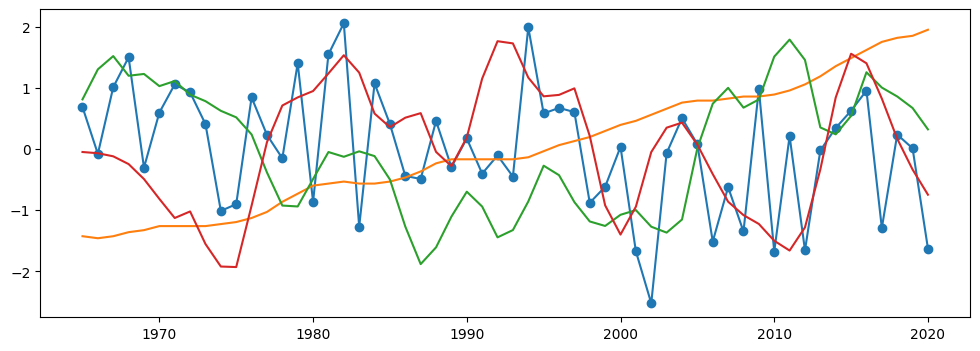

In [ ]:
plt.figure(figsize=(12,4))
plt.scatter(year,y)
plt.plot(year,y)
plt.plot(year,x1)
plt.plot(year,x2)
plt.plot(year,x3)
plt.show()

In [ ]:
initial_params = [0, 0, 0, 0, 1]  # Starting with small coefficients and sigma=1
bounds = [(None, None), (None, None), (None, None), (None, None), (1e-10, None)]

result = minimize(ll_linear, x0=initial_params, args=(y, x1, x2, x3), 
                  bounds=bounds, method='L-BFGS-B')
result.x

array([ 4.20039933e-09, -3.72254649e-01,  2.76697713e-01,  4.55107741e-01,
        8.43059056e-01])

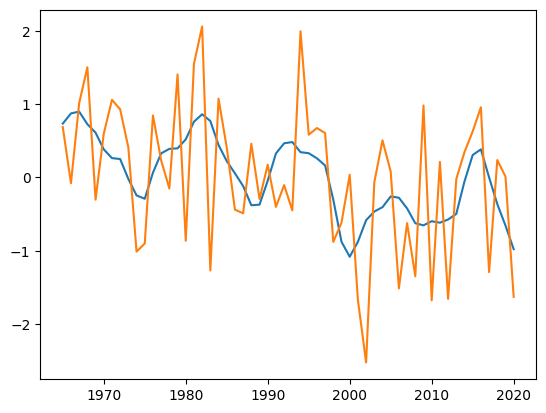

In [ ]:
B0, B1, B2, B3, sigma =result.x
y_fit = B0 + B1 * x1 + B2 * x2 + B3 * x3
plt.plot(year,y_fit)
plt.plot(year,y)

In [ ]:
#By ols
#from sklearn.linear_model import LinearRegression
#X = np.column_stack((x1, x2, x3))
#reg = LinearRegression().fit(X, y)
#initial_params = [reg.intercept_, reg.coef_[0], reg.coef_[1], reg.coef_[2], np.std(y - reg.predict(X))]

In [ ]:
initial_params = [1.43955, -0.358997,1,1,0.55584, -0.309772]
bounds = [(-5, 5), (-5, 5),(-5, 5),(-5, 5), (1e-5, 10), (-2, 2)]
bounds = [(None, None), (None, None),(None, None),(None, None) ,(1e-6, 10), (-2, 2)]

result = minimize(gev_ll,x0 = initial_params, args=(y,x1,x2,x3),method='L-BFGS-B',bounds=bounds)

/Users/luanbrito/Projects/bee_5850_term_project/.venv/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


In [ ]:
result.x

array([ 0.50593585, -0.42917509,  0.6854754 ,  0.84516016,  0.57868376,
       -0.31386036])

In [ ]:
r = 100
p = 1/r
B0, B1, B2, B3, sigma, xi = result.x
mu = B0 + B1 * x1 + B2* x2 + B3 * x3
z100 = mu - sigma / xi * (1 - (-np.log(1 - p)) ** (-xi))

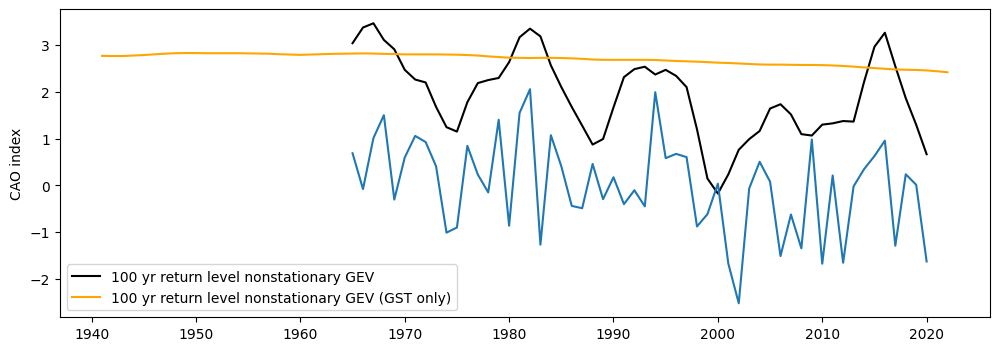

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(year,z100,color="black",label="100 yr return level nonstationary GEV")
plt.plot(dat['year'],np.array(z_gstm),color="orange",label="100 yr return level nonstationary GEV (GST only)")
plt.plot(year,y,c="#1f77b4")
plt.ylabel("CAO index")
plt.legend()
plt.show()

In [ ]:


with pm.Model() as model:
    # Priors
#    μ = pm.Normal("μ", mu=0, sigma=10000)
#    σ = pm.Normal("σ", mu=0, sigma=10000)
#    ξ = pm.Normal("ξ", mu=0, sigma=100)

    B0 = pm.Normal("B0",  mu=0,sigma=5)
    B1 = pm.Normal("B1",  mu=0,sigma=5)
    B2 = pm.Normal("B2",  mu=0,sigma=5)
    B3 = pm.Normal("B3",  mu=0,sigma=5)

    μ = B0 + B1 * x + B2 * z + B3 * w
    σ =pm.HalfNormal("σ", sigma=2)
    ξ = pm.TruncatedNormal("ξ", mu=-0.2, sigma=0.1, lower=-0.6, upper=-0.05)

    # Estimation
    gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ, observed=y)
    # Return level
    #z_p = pm.Deterministic("z_p", μ - σ / ξ * (1 - (-np.log(1 - p)) ** (-ξ)))

NameError: name 'z' is not defined

In [ ]:
idata = pm.sample_prior_predictive(samples=1000, model=model)

Sampling: [B0, B1, B2, B3, gev, ξ, σ]


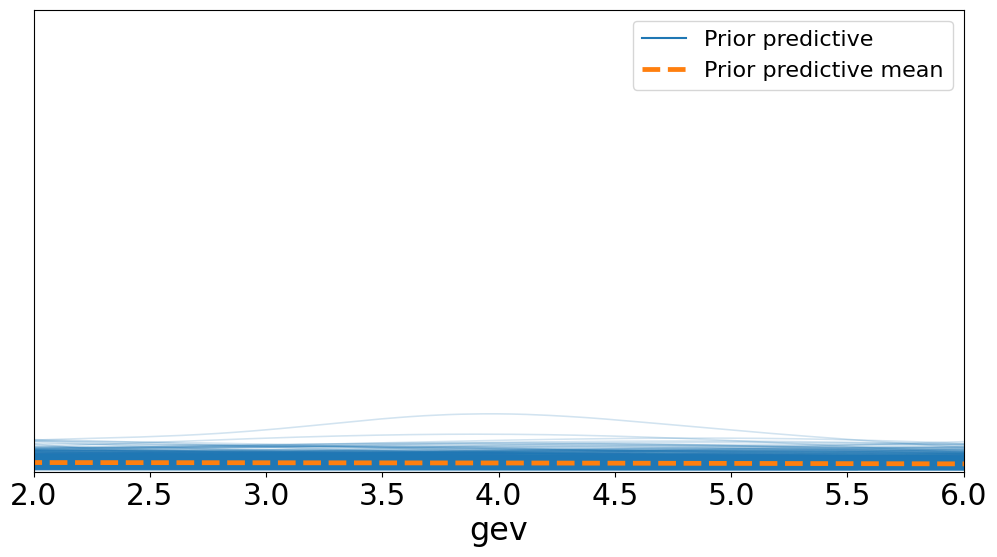

In [ ]:
az.plot_ppc(idata, group="prior", figsize=(12, 6))
ax = plt.gca()
ax.set_xlim([2, 6])
ax.set_ylim([0, 2]);

In [ ]:
with model:
    trace = pm.sample(
        5000,
        cores=4,
        chains=4,
        tune=2000,
        initvals={"B0": 0,"B1": 0,"B2": 0,"B3": 0, "σ": 0.2, "ξ": -0.1},
        target_accept=0.98,
        progressbar = True
    )
# add trace to existing idata object
idata.extend(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [B0, B1, B2, B3, σ, ξ]


Output()

Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 8 seconds.
There were 315 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
az.summary(trace).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
B0 -0.31  0.12   -0.54    -0.08        0.0      0.0   12509.0   12705.0    1.0
B1 -0.37  0.11   -0.58    -0.15        0.0      0.0   13523.0   13822.0    1.0
B2  0.27  0.13    0.04     0.51        0.0      0.0   12121.0   12957.0    1.0
B3  0.44  0.12    0.20     0.67        0.0      0.0   11087.0   11829.0    1.0
σ   0.84  0.07    0.71     0.98        0.0      0.0   13175.0   11084.0    1.0
ξ  -0.29  0.06   -0.41    -0.16        0.0      0.0   10568.0    7965.0    1.0

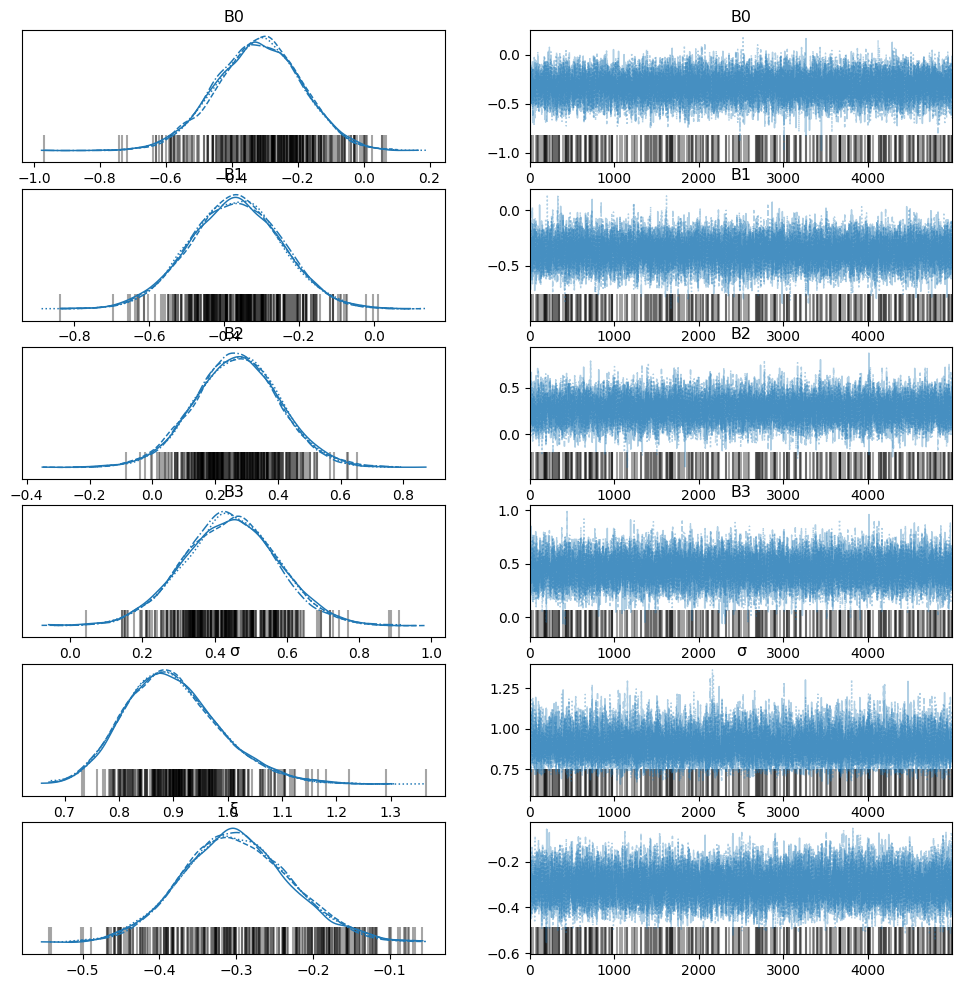

In [ ]:
az.plot_trace(idata, var_names=["B0", "B1", "B2","B3","σ","ξ"], figsize=(12, 12));

In [ ]:
df_samples = idata["posterior"].to_dataframe().reset_index()
df_samples = df_samples[df_samples.chain==0] #Selected samples from one of the chains
df_samples.head(5)

chain  draw        B0        B1        B2        B3         σ         ξ
0      0     0 -0.356272 -0.373245  0.300006  0.506562  0.843815 -0.205301
1      0     1 -0.300038 -0.388568  0.253569  0.458655  0.771014 -0.204622
2      0     2 -0.254761 -0.593016  0.357588  0.506746  0.961798 -0.179405
3      0     3 -0.392076 -0.495507  0.313345  0.688006  0.892567 -0.125250
4      0     4 -0.418103 -0.464634  0.481358  0.434206  0.823580 -0.297158

In [ ]:
return_levels_1941 = np.zeros(np.shape(df_samples)[0])
return_levels_2022 = np.zeros(np.shape(df_samples)[0])

for idx in range(0,np.shape(df_samples)[0]):
    mu_sample_1941 = df_samples["B0"][idx] + df_samples["B1"][idx]*dat.loc[dat['year']==1941,'GSTM'].values[0]
    mu_sample_2022 = df_samples["B0"][idx] + df_samples["B1"][idx]*dat.loc[dat['year']==2022,'GSTM'].values[0]
    #mu_sample = df_samples["μ"][idx]
    sigma_sample= df_samples["σ"][idx]
    xi_sample = df_samples["ξ"][idx]
    params_1941 = np.array([-xi_sample,mu_sample_1941,sigma_sample])
    params_2022  = np.array([-xi_sample,mu_sample_2022,sigma_sample])

    sample_gev_1941  = genextreme(*params_1941)
    sample_gev_2022  = genextreme(*params_2022)

    return_levels_1941[idx] = sample_gev_1941.ppf(1-1/100)
    return_levels_2022[idx] = sample_gev_2022.ppf(1-1/100)